In [85]:
import seaborn as sns
import pandas as pd
import yfinance as yf
import math
import ast
import json
import statistics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
import sys
sys.path.append('../src')
from functions import stock_selection_weight_allocation, adjust_portfolio, calculate_shares_to_buy_with_prices
warnings.filterwarnings("ignore")

In [86]:
stock_selection_methods_to_consider = []
weight_allocation_methods_to_consider = []
backtesting_versions_to_consider = []

In [87]:
# Load the data
data_path = '../data/final_backtesting_summary.csv'  # Update this path to your CSV file location
df = pd.read_csv(data_path, index_col=0)

In [88]:
df = df[df['Stock_Selection_Method'].isin([1,3,5,7,9,11,13,15])]
df = df.rename(columns={'Backtest_Version':'Analysis_Time_Frame_Combinations'})

In [89]:
df.loc[df['Stock_Selection_Method'] == 3, 'Stock_Selection_Method'] = 2
df.loc[df['Stock_Selection_Method'] == 5, 'Stock_Selection_Method'] = 3
df.loc[df['Stock_Selection_Method'] == 7, 'Stock_Selection_Method'] = 4
df.loc[df['Stock_Selection_Method'] == 9, 'Stock_Selection_Method'] = 5
df.loc[df['Stock_Selection_Method'] == 11, 'Stock_Selection_Method'] = 6
df.loc[df['Stock_Selection_Method'] == 13, 'Stock_Selection_Method'] = 7
df.loc[df['Stock_Selection_Method'] == 15, 'Stock_Selection_Method'] = 8

In [90]:
df['Strategy_Combination'] = df['Stock_Selection_Method'].astype(str) + '_' + df['Weight_Allocation_Method'].astype(str) + '_' + df['Analysis_Time_Frame_Combinations'].astype(str)

In [91]:
cols = ['Strategy_Combination'] + [col for col in df.columns if col != 'Strategy_Combination']
df = df[cols]

In [92]:
# Define the function to apply to each row
def calculate_range(row):
    # Create a list from the specified columns
    values = [row['CAGR_4Y'], row['CAGR_3Y'], row['CAGR_2Y'], row['CAGR_1Y']]
    # Find the minimum and maximum
    min_val = min(values)
    max_val = max(values)
    # Calculate the difference
    diff = max_val - min_val
    # Return the values
    return pd.Series([min_val, max_val, diff])

# Apply the function and assign the result to new columns
df[['Min_CAGR', 'Max_CAGR', 'Diff_CAGR']] = df.apply(calculate_range, axis=1)

# Define the function to apply to each row
def calculate_range(row):
    # Create a list from the specified columns
    values = [row['Variance_1Y'], row['Variance_2Y'], row['Variance_3Y'], row['Variance_4Y']]
    # Find the minimum and maximum
    min_val = min(values)
    max_val = max(values)
    # Calculate the difference
    diff = max_val - min_val
    # Return the values
    return pd.Series([min_val, max_val, diff])

# Apply the function and assign the result to new columns
df[['Min_Variance', 'Max_Variance', 'Diff_Variance']] = df.apply(calculate_range, axis=1)

In [93]:
df.sort_values(by='Diff_CAGR').head()[['Strategy_Combination','Diff_CAGR']]

,Strategy_Combination,Diff_CAGR
76,1_6_7,0.15
84,1_7_7,0.15
121,4_7_5,0.18
109,4_6_5,0.18
55,6_10_8,0.18


In [94]:
df.sort_values(by='Diff_Variance').head()[['Strategy_Combination','Diff_Variance']]

,Strategy_Combination,Diff_Variance
36,5_6_5,0.0039
36,5_6_7,0.0039
41,5_7_7,0.0039
41,5_7_5,0.0039
155,8_1_4,0.0043


In [95]:
df['CAGR_analysis'] = df['CAGR_1Y'] + df['CAGR_2Y'] + df['CAGR_3Y'] + df['CAGR_4Y']
df['Variance_analysis'] = df['Variance_1Y'] + df['Variance_2Y'] + df['Variance_3Y'] + df['Variance_4Y']

In [96]:
df.sort_values(by='CAGR_analysis', ascending=False).head()

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
77,3_11_3,3,11,11.44,0.84,0.81,0.83,2.14,13,3,...,3,3m,0.81,2.14,1.33,0.0408,0.0604,0.0196,4.62,0.1849
75,5_11_3,5,11,11.44,0.84,0.81,0.83,2.14,13,3,...,3,3m,0.81,2.14,1.33,0.0408,0.0604,0.0196,4.62,0.1849
170,1_11_3,1,11,11.44,0.84,0.81,0.83,2.14,13,3,...,3,3m,0.81,2.14,1.33,0.0408,0.0604,0.0196,4.62,0.1849
83,3_10_3,3,10,12.20,0.87,0.81,0.82,2.00,13,3,...,3,3m,0.81,2.00,1.19,0.0375,0.0551,0.0176,4.50,0.1710
86,5_10_3,5,10,12.20,0.87,0.81,0.82,2.00,13,3,...,3,3m,0.81,2.00,1.19,0.0375,0.0551,0.0176,4.50,0.1710


In [97]:
df.sort_values(by='Variance_analysis').head()

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
144,6_1_8,6,1,3.73,0.39,0.34,0.18,0.30,34,14,...,8,1m,0.18,0.39,0.21,0.0062,0.0253,0.0191,1.21,0.0451
144,6_1_10,6,1,3.73,0.39,0.34,0.18,0.30,34,14,...,10,1m,0.18,0.39,0.21,0.0062,0.0253,0.0191,1.21,0.0451
90,3_7_5,3,7,3.94,0.41,0.35,0.27,0.51,12,4,...,5,3m,0.27,0.51,0.24,0.0086,0.0166,0.0080,1.54,0.0479
105,3_6_5,3,6,3.94,0.41,0.35,0.27,0.51,12,4,...,5,3m,0.27,0.51,0.24,0.0086,0.0166,0.0080,1.54,0.0479
76,1_6_9,1,6,3.58,0.38,0.38,0.31,0.51,12,4,...,9,3m,0.31,0.51,0.20,0.0086,0.0158,0.0072,1.58,0.0497


In [98]:
df['Stock_Selection_Method'] = 'S' + df['Stock_Selection_Method'].astype(str)
df['Weight_Allocation_Method'] = 'A' + df['Weight_Allocation_Method'].astype(str)
df['Analysis_Time_Frame_Combinations'] = 'T' + df['Analysis_Time_Frame_Combinations'].astype(str)

In [99]:
df

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
0,7_8_1,S7,A8,10.69,0.81,0.68,0.56,1.24,12,4,...,T1,3m,0.56,1.24,0.68,0.0305,0.0815,0.0510,3.29,0.2355
9,7_9_1,S7,A9,7.61,0.66,0.58,0.58,1.18,11,5,...,T1,3m,0.58,1.18,0.60,0.0324,0.0670,0.0346,3.00,0.2132
10,8_10_1,S8,A10,10.50,0.80,0.50,0.43,1.14,33,15,...,T1,1m,0.43,1.14,0.71,0.0141,0.0811,0.0670,2.87,0.1638
11,6_9_1,S6,A9,6.25,0.58,0.36,0.25,1.17,31,17,...,T1,1m,0.25,1.17,0.92,0.0333,0.0616,0.0283,2.36,0.1791
16,6_8_1,S6,A8,6.15,0.57,0.43,0.31,1.05,31,17,...,T1,1m,0.31,1.05,0.74,0.0240,0.0386,0.0146,2.36,0.1220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,1_10_10,S1,A10,4.39,0.45,0.40,0.42,0.80,11,5,...,T10,3m,0.40,0.80,0.40,0.0377,0.0911,0.0534,2.07,0.2278
170,1_11_10,S1,A11,4.35,0.44,0.42,0.40,0.74,10,6,...,T10,3m,0.40,0.74,0.34,0.0331,0.0769,0.0438,2.00,0.1931
171,8_3_10,S8,A3,5.04,0.50,0.20,0.01,0.63,26,22,...,T10,1m,0.01,0.63,0.62,0.0525,0.3413,0.2888,1.34,0.5169
174,6_7_10,S6,A7,4.50,0.46,0.45,0.33,0.23,34,14,...,T10,1m,0.23,0.46,0.23,0.0073,0.0251,0.0178,1.47,0.0527


In [100]:
df_backup = df.copy()

In [101]:
max_success_rate = max(list(df['Success_Rate']))
df_max_success_rate = df[df['Success_Rate']==max_success_rate]

In [102]:
max_return_max_success_rate = max(list(df_max_success_rate['CAGR_4Y']))
df_max_return_max_success_rate = df_max_success_rate[df_max_success_rate['CAGR_4Y']==max_return_max_success_rate]

for i in range(len(df_max_return_max_success_rate)):
    stock_selection_methods_to_consider.append(df_max_return_max_success_rate['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_max_return_max_success_rate['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_max_return_max_success_rate['Analysis_Time_Frame_Combinations'].iloc[i])

print('Strategies with the maximum 4 year CAGR out of the strategies with the maximum success rate:')
df_max_return_max_success_rate

Strategies with the maximum 4 year CAGR out of the strategies with the maximum success rate:


,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
149,7_7_5,S7,A7,9.5,0.76,0.74,0.64,1.28,14,2,...,T5,3m,0.64,1.28,0.64,0.02,0.0452,0.0252,3.42,0.1198
161,7_6_5,S7,A6,9.5,0.76,0.74,0.64,1.28,14,2,...,T5,3m,0.64,1.28,0.64,0.02,0.0452,0.0252,3.42,0.1198


In [103]:
min_variance_max_success_rate = min(list(df_max_success_rate['Variance_4Y']))
df_min_variance_max_success_rate = df_max_success_rate[df_max_success_rate['Variance_4Y']==min_variance_max_success_rate]

for i in range(len(df_min_variance_max_success_rate)):
    stock_selection_methods_to_consider.append(df_min_variance_max_success_rate['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_min_variance_max_success_rate['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_min_variance_max_success_rate['Analysis_Time_Frame_Combinations'].iloc[i])

print('Strategies with the minimum 4 year variance out of the strategies with the maximum success rate:')
df_min_variance_max_success_rate

Strategies with the minimum 4 year variance out of the strategies with the maximum success rate:


,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
149,7_7_5,S7,A7,9.5,0.76,0.74,0.64,1.28,14,2,...,T5,3m,0.64,1.28,0.64,0.02,0.0452,0.0252,3.42,0.1198
161,7_6_5,S7,A6,9.5,0.76,0.74,0.64,1.28,14,2,...,T5,3m,0.64,1.28,0.64,0.02,0.0452,0.0252,3.42,0.1198


In [104]:
max_return = max(list(df['CAGR_4Y']))
df_max_return = df[df['CAGR_4Y']==max_return]

for i in range(len(df_max_return)):
    stock_selection_methods_to_consider.append(df_max_return['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_max_return['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_max_return['Analysis_Time_Frame_Combinations'].iloc[i])

df_max_return

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
58,4_3_10,S4,A3,41.83,1.54,0.92,0.4,0.94,34,14,...,T10,1m,0.4,1.54,1.14,0.0262,0.1796,0.1534,3.8,0.3217


In [105]:
min_variance = min(list(df['Variance_4Y']))
df_min_variance = df[df['Variance_4Y']==min_variance]

for i in range(len(df_min_variance)):
    stock_selection_methods_to_consider.append(df_min_variance['Stock_Selection_Method'].iloc[i])
    weight_allocation_methods_to_consider.append(df_min_variance['Weight_Allocation_Method'].iloc[i])
    backtesting_versions_to_consider.append(df_min_variance['Analysis_Time_Frame_Combinations'].iloc[i])

df_min_variance

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
36,5_6_5,S5,A6,2.67,0.28,0.29,0.19,0.47,12,4,...,T5,3m,0.19,0.47,0.28,0.0125,0.0164,0.0039,1.23,0.0569
41,5_7_5,S5,A7,2.67,0.28,0.29,0.19,0.47,12,4,...,T5,3m,0.19,0.47,0.28,0.0125,0.0164,0.0039,1.23,0.0569


In [106]:
# Calculate averages for CAGR, Variance, and Success Rate
avg_cagr_4y_by_stock_selection = df.groupby('Stock_Selection_Method')['CAGR_4Y'].mean()
avg_cagr_4y_by_weight_allocation = df.groupby('Weight_Allocation_Method')['CAGR_4Y'].mean()
avg_cagr_4y_by_rebalance = df.groupby('Rebalance')['CAGR_4Y'].mean()
avg_cagr_4y_by_Analysis_Time_Frame_Combinations = df.groupby('Analysis_Time_Frame_Combinations')['CAGR_4Y'].mean()

avg_variance_4y_by_stock_selection = df.groupby('Stock_Selection_Method')['Variance_4Y'].mean()
avg_variance_4y_by_weight_allocation = df.groupby('Weight_Allocation_Method')['Variance_4Y'].mean()
avg_variance_4y_by_rebalance = df.groupby('Rebalance')['Variance_4Y'].mean()
avg_variance_4y_by_Analysis_Time_Frame_Combinations = df.groupby('Analysis_Time_Frame_Combinations')['Variance_4Y'].mean()

success_rate_by_stock_selection = df.groupby('Stock_Selection_Method')['Success_Rate'].mean()
success_rate_by_weight_allocation = df.groupby('Weight_Allocation_Method')['Success_Rate'].mean()
success_rate_by_rebalance = df.groupby('Rebalance')['Success_Rate'].mean()
success_rate_by_Analysis_Time_Frame_Combinations = df.groupby('Analysis_Time_Frame_Combinations')['Success_Rate'].mean()

In [107]:
def create_bar_graphs(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    
    data = pd.DataFrame(data).reset_index()
    data.columns = [xlabel, ylabel]
    data = data.reset_index(drop=True)
    data_sorted = data.sort_values(by=ylabel, ascending=False)

    sns.barplot(x=data_sorted[xlabel], y=ylabel, data=data_sorted, palette="viridis", order=data_sorted[xlabel])
    # sns.barplot(x=xlabel, y=ylabel, data=data, palette="viridis")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
    plt.show()

In [108]:
# Function to plot density curves with updated colors
def plot_density_curves_for_comparison(data, ids, metric, title, xlabel, ylabel, category_label):
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("dark", n_colors=len(ids))  # Use a dark color palette for clarity
    for i, id in enumerate(ids):
        subset = data[data[category_label] == id]
        sns.kdeplot(subset[metric], color=colors[i % len(colors)], label=f'{id}', bw_adjust=0.5)
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if metric.startswith('Variance'):
        plt.xlim(-0.2, 0.5)
    plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
    plt.show()

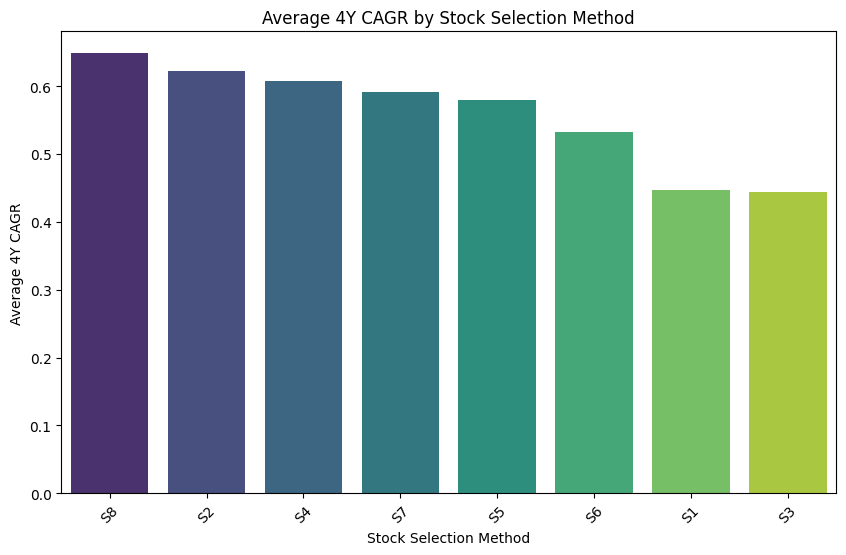

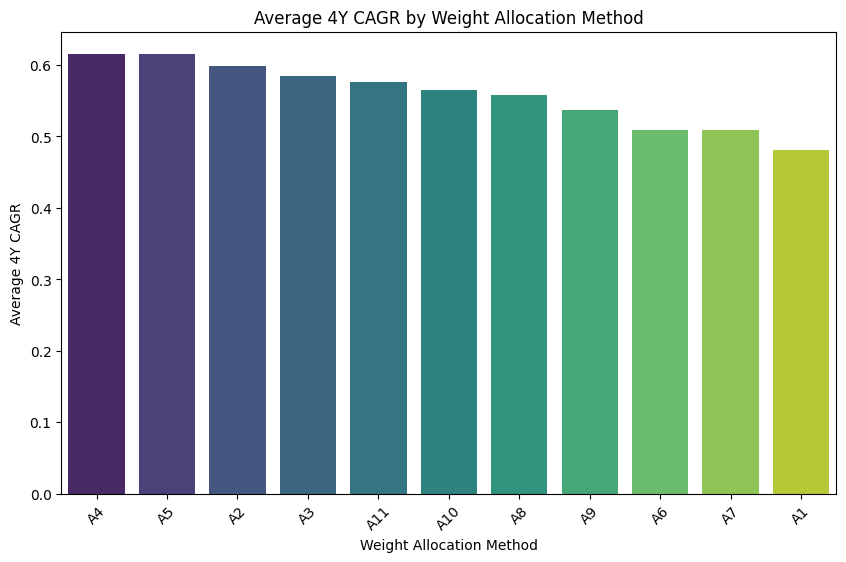

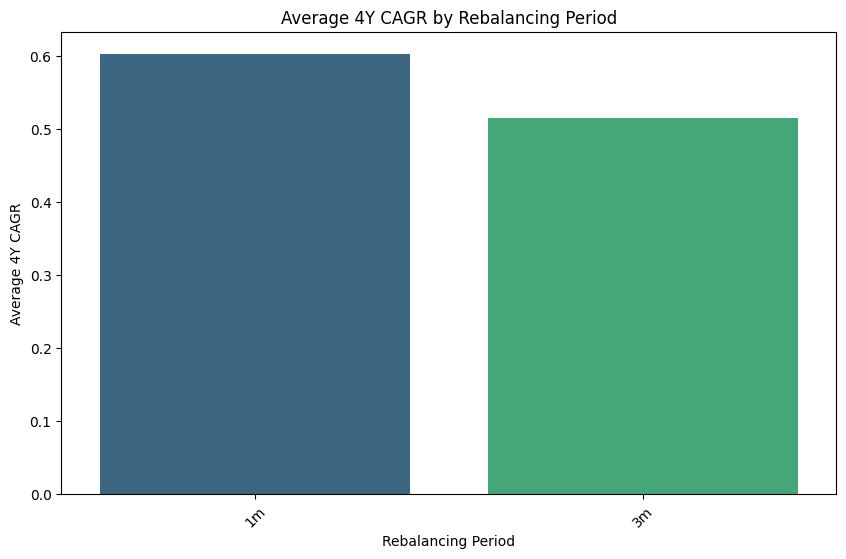

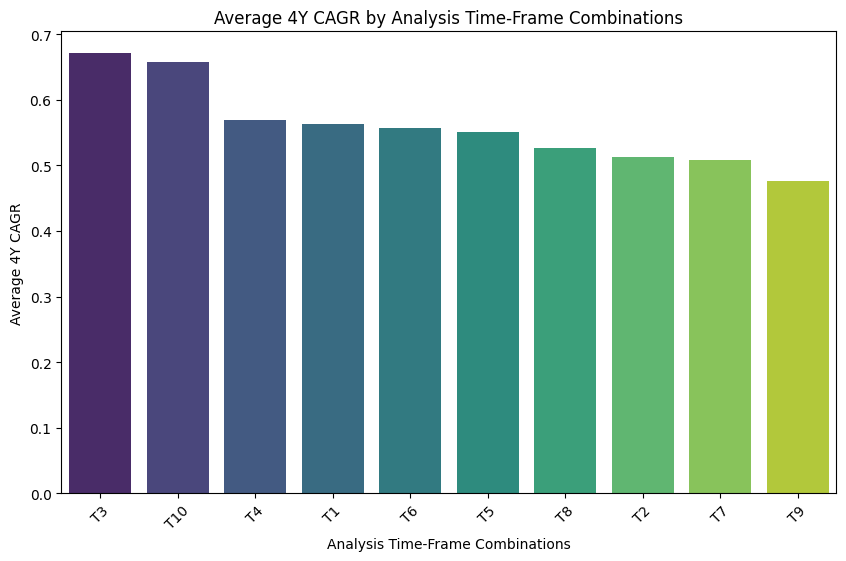

In [109]:
create_bar_graphs(avg_cagr_4y_by_stock_selection, 'Average 4Y CAGR by Stock Selection Method', 'Stock Selection Method', 'Average 4Y CAGR')
create_bar_graphs(avg_cagr_4y_by_weight_allocation, 'Average 4Y CAGR by Weight Allocation Method', 'Weight Allocation Method', 'Average 4Y CAGR')
create_bar_graphs(avg_cagr_4y_by_rebalance, 'Average 4Y CAGR by Rebalancing Period', 'Rebalancing Period', 'Average 4Y CAGR')
create_bar_graphs(avg_cagr_4y_by_Analysis_Time_Frame_Combinations, 'Average 4Y CAGR by Analysis Time-Frame Combinations', 'Analysis Time-Frame Combinations', 'Average 4Y CAGR')

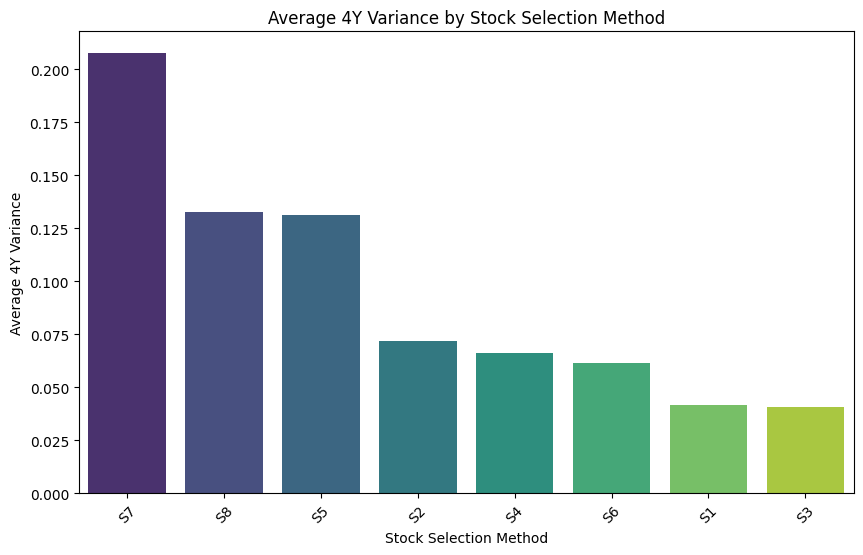

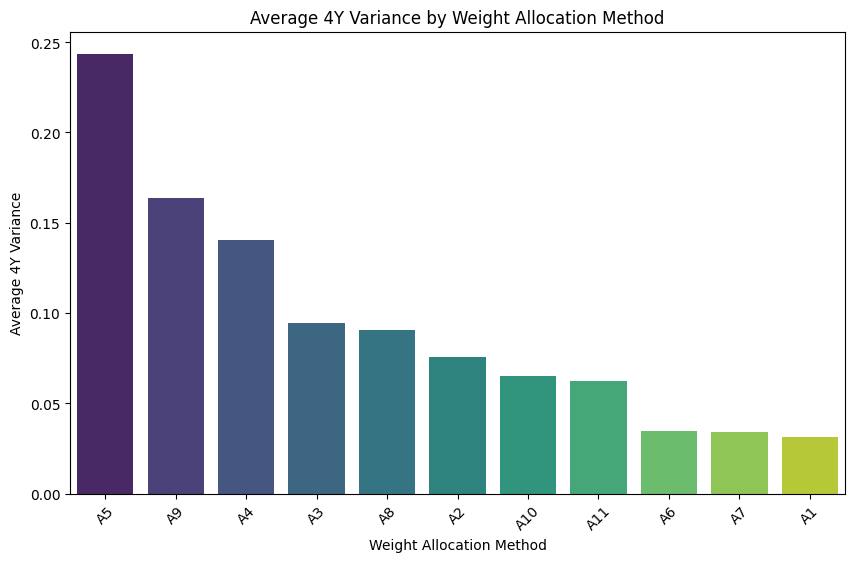

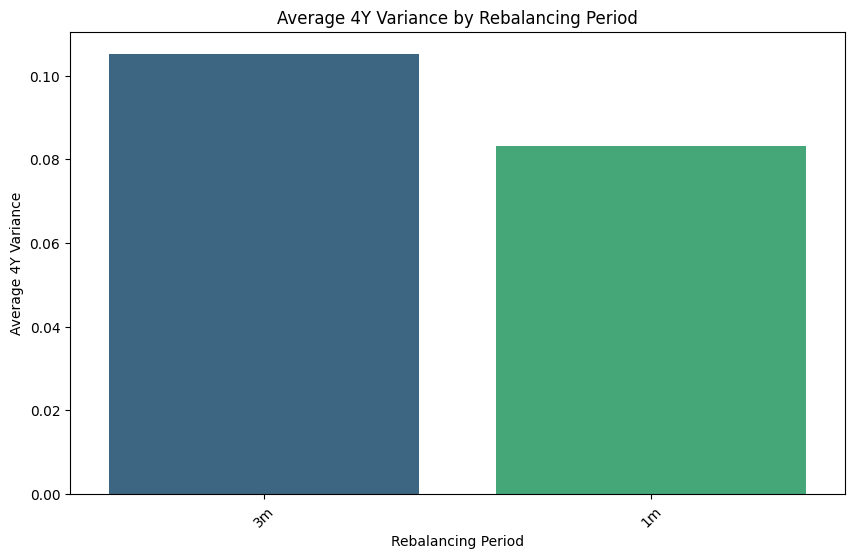

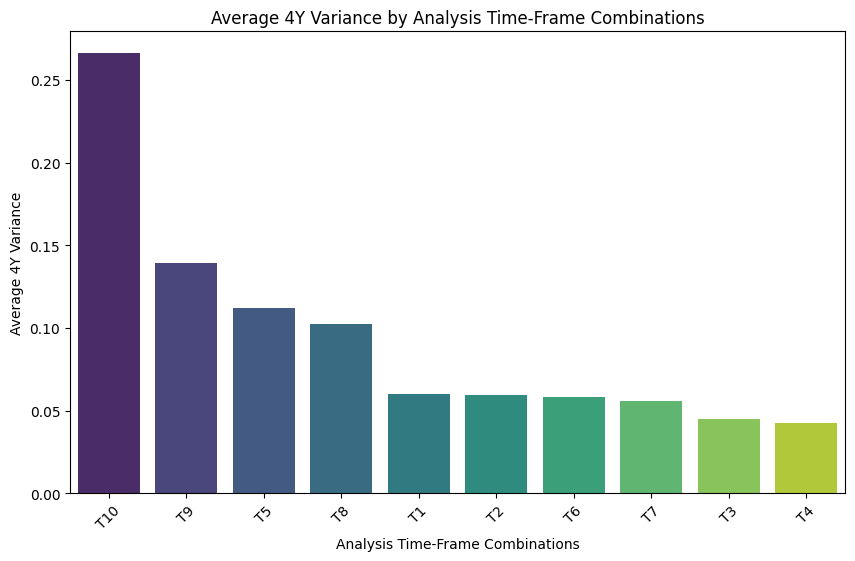

In [110]:
create_bar_graphs(avg_variance_4y_by_stock_selection, 'Average 4Y Variance by Stock Selection Method', 'Stock Selection Method', 'Average 4Y Variance')
create_bar_graphs(avg_variance_4y_by_weight_allocation, 'Average 4Y Variance by Weight Allocation Method', 'Weight Allocation Method', 'Average 4Y Variance')
create_bar_graphs(avg_variance_4y_by_rebalance, 'Average 4Y Variance by Rebalancing Period', 'Rebalancing Period', 'Average 4Y Variance')
create_bar_graphs(avg_variance_4y_by_Analysis_Time_Frame_Combinations, 'Average 4Y Variance by Analysis Time-Frame Combinations', 'Analysis Time-Frame Combinations', 'Average 4Y Variance')

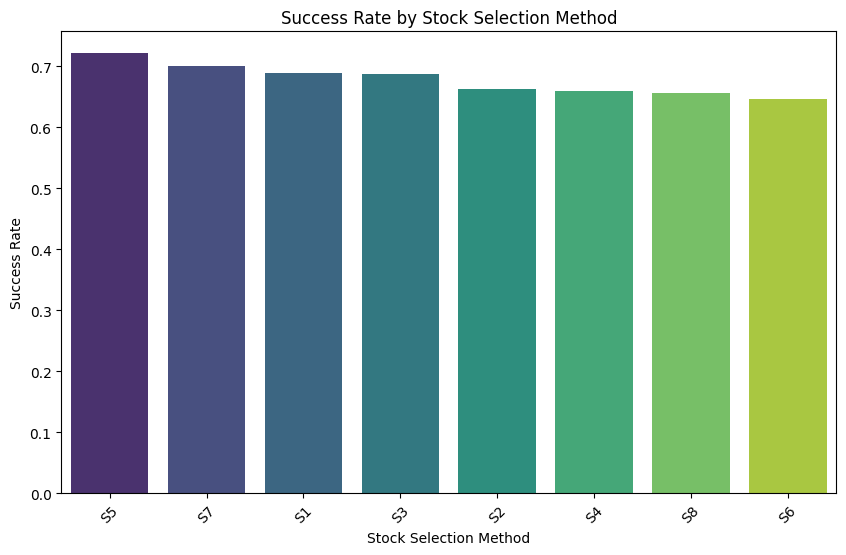

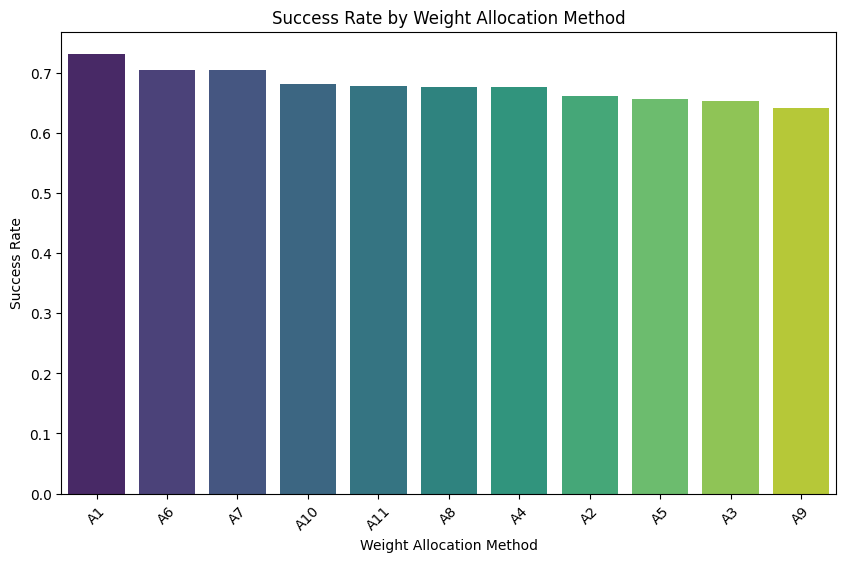

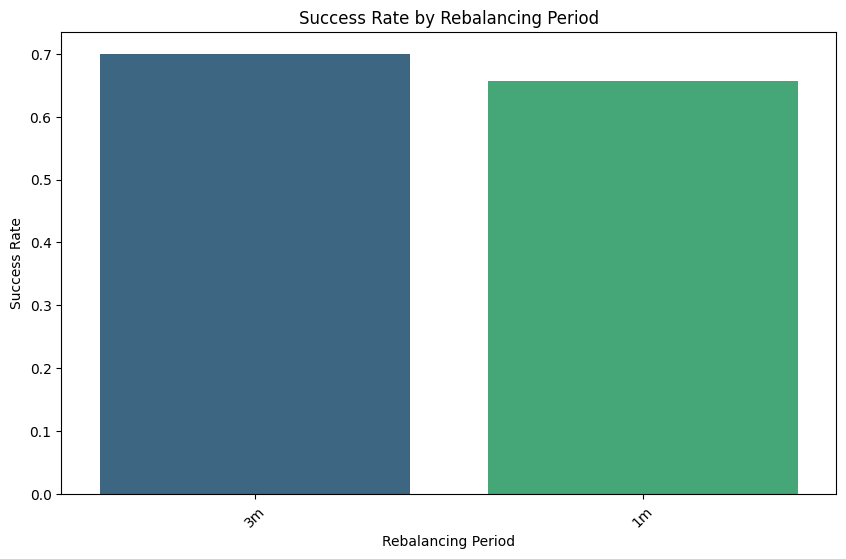

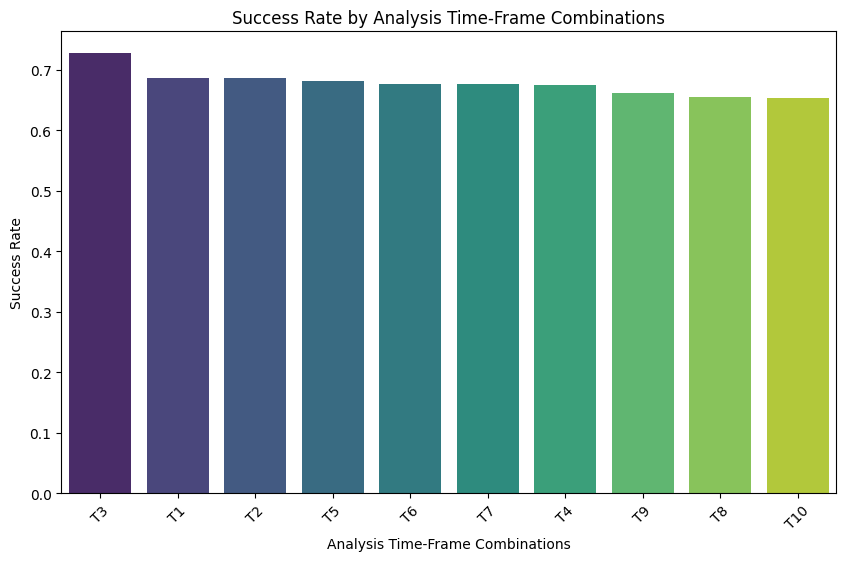

In [111]:
create_bar_graphs(success_rate_by_stock_selection, 'Success Rate by Stock Selection Method', 'Stock Selection Method', 'Success Rate')
create_bar_graphs(success_rate_by_weight_allocation, 'Success Rate by Weight Allocation Method', 'Weight Allocation Method', 'Success Rate')
create_bar_graphs(success_rate_by_rebalance, 'Success Rate by Rebalancing Period', 'Rebalancing Period', 'Success Rate')
create_bar_graphs(success_rate_by_Analysis_Time_Frame_Combinations, 'Success Rate by Analysis Time-Frame Combinations', 'Analysis Time-Frame Combinations', 'Success Rate')

In [112]:
all_stocks_df = pd.read_csv('../data/all_stock_data.csv', index_col=0)
all_stocks_df.index = pd.to_datetime(all_stocks_df.index)

In [113]:
final_symbols = list(all_stocks_df.columns)

In [114]:
govt_bond_df = pd.read_csv('../data/India 10-Year Bond Yield Historical Data.csv')
govt_bond_df = govt_bond_df[['Date','Price']]
govt_bond_df.index = govt_bond_df['Date']
govt_bond_df = govt_bond_df.drop('Date', axis=1)
govt_bond_df.index = pd.to_datetime(govt_bond_df.index)

In [115]:
def get_dates_in_range(start_date, end_date, months):
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    # Calculate end date by subtracting one month from the given end date
    end_date = datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(months=months)
    
    # Generate a list of dates in the desired format
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    
    return date_list

In [116]:
start_date = '2023-10-01'
end_date = '2024-03-28'

backtesting_buying_dates_for_1m_hold = get_dates_in_range(start_date, end_date, 1)
backtesting_buying_dates_for_1q_hold = get_dates_in_range(start_date, end_date, 3)

In [117]:
market_dates_ = list(all_stocks_df.index)
market_dates = []
for date in market_dates_:
    market_dates.append(str(date)[:10])

In [118]:
backtesting_buying_dates_for_1q_hold_ = []
for date in backtesting_buying_dates_for_1q_hold:
    if date in market_dates:
        backtesting_buying_dates_for_1q_hold_.append(date)

backtesting_buying_dates_for_1q_hold = backtesting_buying_dates_for_1q_hold_

backtesting_buying_dates_for_1q_hold, len(backtesting_buying_dates_for_1q_hold)

(['2023-10-03',
  '2023-10-04',
  '2023-10-05',
  '2023-10-06',
  '2023-10-09',
  '2023-10-10',
  '2023-10-11',
  '2023-10-12',
  '2023-10-13',
  '2023-10-16',
  '2023-10-17',
  '2023-10-18',
  '2023-10-19',
  '2023-10-20',
  '2023-10-23',
  '2023-10-25',
  '2023-10-26',
  '2023-10-27',
  '2023-10-30',
  '2023-10-31',
  '2023-11-01',
  '2023-11-02',
  '2023-11-03',
  '2023-11-06',
  '2023-11-07',
  '2023-11-08',
  '2023-11-09',
  '2023-11-10',
  '2023-11-13',
  '2023-11-15',
  '2023-11-16',
  '2023-11-17',
  '2023-11-20',
  '2023-11-21',
  '2023-11-22',
  '2023-11-23',
  '2023-11-24',
  '2023-11-28',
  '2023-11-29',
  '2023-11-30',
  '2023-12-01',
  '2023-12-04',
  '2023-12-05',
  '2023-12-06',
  '2023-12-07',
  '2023-12-08',
  '2023-12-11',
  '2023-12-12',
  '2023-12-13',
  '2023-12-14',
  '2023-12-15',
  '2023-12-18',
  '2023-12-19',
  '2023-12-20',
  '2023-12-21',
  '2023-12-22',
  '2023-12-26',
  '2023-12-27',
  '2023-12-28'],
 59)

In [119]:
backtesting_buying_dates_for_1m_hold_ = []
for date in backtesting_buying_dates_for_1m_hold:
    if date in market_dates:
        backtesting_buying_dates_for_1m_hold_.append(date)

backtesting_buying_dates_for_1m_hold = backtesting_buying_dates_for_1m_hold_[:59]

backtesting_buying_dates_for_1m_hold, len(backtesting_buying_dates_for_1m_hold)

(['2023-10-03',
  '2023-10-04',
  '2023-10-05',
  '2023-10-06',
  '2023-10-09',
  '2023-10-10',
  '2023-10-11',
  '2023-10-12',
  '2023-10-13',
  '2023-10-16',
  '2023-10-17',
  '2023-10-18',
  '2023-10-19',
  '2023-10-20',
  '2023-10-23',
  '2023-10-25',
  '2023-10-26',
  '2023-10-27',
  '2023-10-30',
  '2023-10-31',
  '2023-11-01',
  '2023-11-02',
  '2023-11-03',
  '2023-11-06',
  '2023-11-07',
  '2023-11-08',
  '2023-11-09',
  '2023-11-10',
  '2023-11-13',
  '2023-11-15',
  '2023-11-16',
  '2023-11-17',
  '2023-11-20',
  '2023-11-21',
  '2023-11-22',
  '2023-11-23',
  '2023-11-24',
  '2023-11-28',
  '2023-11-29',
  '2023-11-30',
  '2023-12-01',
  '2023-12-04',
  '2023-12-05',
  '2023-12-06',
  '2023-12-07',
  '2023-12-08',
  '2023-12-11',
  '2023-12-12',
  '2023-12-13',
  '2023-12-14',
  '2023-12-15',
  '2023-12-18',
  '2023-12-19',
  '2023-12-20',
  '2023-12-21',
  '2023-12-22',
  '2023-12-26',
  '2023-12-27',
  '2023-12-28'],
 59)

In [120]:
# 1 - 1,2
# 2 - 3,4
# 3 - 5,6
# 4 - 7,8
# 5 - 9,10
# 6 - 11,12
# 7 - 13,14
# 8 - 15,16

In [121]:
# 7_7_5 - highest success rate
# 4_3_10 - highest 4y cagr
# 5_7_5 - lowest 4y variance

# 1_6_7 - lowest cagr diff between the highest cagr and lowest cagr from [cagr 1y, cagr 2y, cagr 3y, cagr 4y]
# 4_7_5 - second lowest cagr diff between the highest cagr and lowest cagr from [cagr 1y, cagr 2y, cagr 3y, cagr 4y]

# 5_6_5 - lowest variance diff between the highest variance and lowest variance from [variance 1y, variance 2y, variance 3y, variance 4y]
# 5_6_7 - second lowest variance diff between the highest variance and lowest variance from [variance 1y, variance 2y, variance 3y, variance 4y]
# 8_1_4 - third lowest variance diff between the highest variance and lowest variance from [variance 1y, variance 2y, variance 3y, variance 4y]

# 3_11_3 - highest average of 4y cagr, 3y cagr, 2y cagr, and 1y cagr
# 3_10_3 - second highest average of 4y cagr, 3y cagr, 2y cagr, and 1y cagr

# 6_1_8 - lowest average variance of 4y variance, 3y variance, 2y variance, and 1y variance
# 3_7_5 - second lowest average variance of 4y variance, 3y variance, 2y variance, and 1y variance
# 1_6_9 - third lowest average variance of 4y variance, 3y variance, 2y variance, and 1y variance

In [122]:
bt_v_list = [(1,1), (1,2), (2,1), (2,2), (0.5,0.5), (1,0.5), (0.5,1), (0.25,0.25), (0.5,0.25), (0.25,0.5)]
strategies_selected = [(13,7,5),(7,3,10),(9,6,5),(1,6,7),(7,7,5),(9,6,7),(15,1,4),(5,11,3),(5,10,3),(11,1,8),(5,7,5),(1,6,9)]

In [123]:
def save_dict_to_json(data, filename):
    """
    Saves a dictionary to a JSON file.

    Parameters:
    - data (dict): The dictionary to save.
    - filename (str): The name of the file to save the dictionary to.
    """
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

In [124]:
def load_json_to_dict(filename):
    """
    Loads JSON data from a file and returns it as a dictionary.

    Parameters:
    - filename (str): The name of the JSON file to read from.
    
    Returns:
    - dict: The dictionary containing the data read from the JSON file.
    """
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

In [125]:
try:
    strategy_performance_dict = load_json_to_dict('../data/last_4_months_results.json')
    x = len(strategy_performance_dict)
except:
    strategy_performance_dict = {}
    x = 1

# Iterate over all strategy combinations
for strategy in strategies_selected[x-1:]:

    try:
        y = len(strategy_performance_dict[str(strategy)])
        transactions = strategy_performance_dict[str(strategy)]
    except:
        y = 0
        transactions = []

    stock_selection_strategy = strategy[0]
    weight_allocation_strategy = strategy[1]
    bt_v = strategy[2]
    last_x_years = bt_v_list[bt_v-1][0]
    last_x_years_opt = bt_v_list[bt_v-1][1]

    print(stock_selection_strategy, weight_allocation_strategy, bt_v, last_x_years, last_x_years_opt)

    if stock_selection_strategy in [1,2,5,6,9,10,13,14]:
        holding_period = '1q'
    elif stock_selection_strategy in [3,4,7,8,11,12,15,16]:
        holding_period = '1m'

    dates = backtesting_buying_dates_for_1m_hold if holding_period == '1m' else backtesting_buying_dates_for_1q_hold
    
    filters = 4

    if stock_selection_strategy in [1,2,5,6,9,10,13,14]:
        holding_period = '1q'
    elif stock_selection_strategy in [3,4,7,8,11,12,15,16]:
        holding_period = '1m'

    if stock_selection_strategy in [1,3,5,7,9,11,13,15]:
        returns_type = 'SR'
    elif stock_selection_strategy in [2,4,6,8,10,12,14,16]:
        returns_type = 'LR'

    if stock_selection_strategy in [1,2,3,4]:
        max_non_positive_returns_count = 15
    elif stock_selection_strategy in [5,6,7,8]:
        max_non_positive_returns_count = 10
    elif stock_selection_strategy in [9,10,11,12]:
        max_non_positive_returns_count = None
        filters = 3
    elif stock_selection_strategy in [13,14,15,16]:
        max_non_positive_returns_count = None
        filters = 2

    for buy_date in dates[y:]:

        portfolio, sell_date, best_method = stock_selection_weight_allocation(buy_date, holding_period, returns_type, max_non_positive_returns_count, weight_allocation_strategy, all_stocks_df, govt_bond_df, filters, last_x_years, last_x_years_opt)
        
        portfolio = adjust_portfolio(portfolio)

        current_cash = 100000.00

        # Calculate the allocated cash for each stock in the portfolio
        allocated_cash = {stock: current_cash * weight for stock, weight in portfolio.items()}

        # Adjust buy_date and sell_date to the nearest next available date in all_stocks_df
        adjusted_buy_date = all_stocks_df[all_stocks_df.index >= buy_date].index[0]
        try:
            adjusted_sell_date = all_stocks_df[all_stocks_df.index >= sell_date].index[0]
        except:
            adjusted_sell_date = all_stocks_df[all_stocks_df.index <= sell_date].index[-1]

        # Get stock prices on buying and selling dates
        buy_prices = all_stocks_df.loc[adjusted_buy_date, portfolio.keys()]
        sell_prices = all_stocks_df.loc[adjusted_sell_date, portfolio.keys()]

        # Calculate the number of shares bought for each stock
        buy_quantities = {stock: allocated_cash[stock] / buy_prices[stock] for stock in portfolio.keys()}

        # Calculate the value of the portfolio at selling date
        sell_values = {stock: sell_prices[stock] * buy_quantities[stock] for stock in portfolio.keys()}
        
        current_cash = round(sum(sell_values.values()),2)
        
        # Record the transaction details
        transaction = {
            'buy_date': str(adjusted_buy_date),
            'sell_date': str(adjusted_sell_date),
            'portfolio': portfolio,
            'sell_price': current_cash
        }

        transactions.append(transaction)
        strategy_performance_dict[str(strategy)] = transactions
        save_dict_to_json(strategy_performance_dict, '../data/last_4_months_results.json')
        
        print(f'Done {buy_date}')

1 6 9 0.5 0.25


In [126]:
strategy_performance_dict = load_json_to_dict('../data/last_4_months_results.json')

In [127]:
strategy_performance_dict

{'(13, 7, 5)': [{'buy_date': '2023-10-03 00:00:00',
   'sell_date': '2024-01-03 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'SUZLON.NS': 0.125,
    'BSE.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'IRFC.NS': 0.125,
    'RESPONIND.NS': 0.125},
   'sell_price': 125930.22},
  {'buy_date': '2023-10-04 00:00:00',
   'sell_date': '2024-01-04 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'SUZLON.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125,
    'TITAGARH.NS': 0.125},
   'sell_price': 137392.35},
  {'buy_date': '2023-10-05 00:00:00',
   'sell_date': '2024-01-05 00:00:00',
   'portfolio': {'SUZLON.NS': 0.125,
    'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125},
   'sell_price': 137018.31},
  {'buy_date': '2023-10-06 00:00:00',
   'sell_date': '2024-0

In [128]:
super_strategies = []
for strategy, result in strategy_performance_dict.items():
    print(strategy)
    count_n = 0
    count_p = 0
    for r in result:
        if r['sell_price'] <= 100000:
            count_n += 1
        else:
            count_p += 1

    print('Positie Return Count:', count_p)
    print('Negative Return Count:', count_n)
    print('Success Rate:', (count_p/(count_n+count_p))*100, '%')
    if count_n/(count_n+count_p) <= 0.1:
        super_strategies.append(strategy)
    print('*****')

(13, 7, 5)
Positie Return Count: 57
Negative Return Count: 2
Success Rate: 96.61016949152543 %
*****
(7, 3, 10)
Positie Return Count: 52
Negative Return Count: 7
Success Rate: 88.13559322033898 %
*****
(9, 6, 5)
Positie Return Count: 59
Negative Return Count: 0
Success Rate: 100.0 %
*****
(1, 6, 7)
Positie Return Count: 50
Negative Return Count: 9
Success Rate: 84.7457627118644 %
*****
(7, 7, 5)
Positie Return Count: 52
Negative Return Count: 7
Success Rate: 88.13559322033898 %
*****
(9, 6, 7)
Positie Return Count: 59
Negative Return Count: 0
Success Rate: 100.0 %
*****
(15, 1, 4)
Positie Return Count: 59
Negative Return Count: 0
Success Rate: 100.0 %
*****
(5, 11, 3)
Positie Return Count: 59
Negative Return Count: 0
Success Rate: 100.0 %
*****
(5, 10, 3)
Positie Return Count: 59
Negative Return Count: 0
Success Rate: 100.0 %
*****
(11, 1, 8)
Positie Return Count: 57
Negative Return Count: 2
Success Rate: 96.61016949152543 %
*****
(5, 7, 5)
Positie Return Count: 50
Negative Return Coun

In [129]:
super_strategies

['(13, 7, 5)',
 '(9, 6, 5)',
 '(9, 6, 7)',
 '(15, 1, 4)',
 '(5, 11, 3)',
 '(5, 10, 3)',
 '(11, 1, 8)']

In [130]:
super_strategies_performance_dict = {}
for s in super_strategies:
    super_strategies_performance_dict[s] = strategy_performance_dict[s]

super_strategies_performance_dict

{'(13, 7, 5)': [{'buy_date': '2023-10-03 00:00:00',
   'sell_date': '2024-01-03 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'SUZLON.NS': 0.125,
    'BSE.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'IRFC.NS': 0.125,
    'RESPONIND.NS': 0.125},
   'sell_price': 125930.22},
  {'buy_date': '2023-10-04 00:00:00',
   'sell_date': '2024-01-04 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'SUZLON.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125,
    'TITAGARH.NS': 0.125},
   'sell_price': 137392.35},
  {'buy_date': '2023-10-05 00:00:00',
   'sell_date': '2024-01-05 00:00:00',
   'portfolio': {'SUZLON.NS': 0.125,
    'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125},
   'sell_price': 137018.31},
  {'buy_date': '2023-10-06 00:00:00',
   'sell_date': '2024-0

In [131]:
strategy_sell_price_dict = {}
for strategy, portfolios in super_strategies_performance_dict.items():
    strategy_sell_price_dict[strategy] = []
    if len(portfolios) == 65:
        for portfolio in portfolios:
            strategy_sell_price_dict[strategy].append(round((portfolio['sell_price']/100000)-1,4))
    else:
        for portfolio in portfolios:
            return_quarterly = (portfolio['sell_price']/100000)-1
            strategy_sell_price_dict[strategy].append(round(((1+return_quarterly)**(1/3))-1,4))

In [132]:
strategy_sell_price_dict

{'(13, 7, 5)': [0.0799,
  0.1117,
  0.1107,
  0.1168,
  0.1333,
  0.1151,
  0.1119,
  0.1173,
  0.1011,
  0.0863,
  0.1053,
  0.0825,
  0.0911,
  0.0765,
  0.0936,
  0.0992,
  0.1171,
  0.0662,
  0.0648,
  0.0979,
  0.1021,
  0.1002,
  0.0996,
  0.0772,
  0.0759,
  0.0829,
  0.0839,
  0.0661,
  0.0499,
  0.0637,
  0.0517,
  0.0477,
  0.0388,
  0.0343,
  0.0451,
  0.0463,
  0.0591,
  0.0497,
  0.0588,
  0.046,
  0.0444,
  0.0379,
  0.041,
  0.0424,
  0.0559,
  0.0337,
  0.0458,
  0.0499,
  -0.005,
  0.0022,
  0.0266,
  0.0103,
  0.0023,
  0.0229,
  0.0272,
  0.0243,
  -0.0139,
  0.0209,
  0.0465],
 '(9, 6, 5)': [0.0313,
  0.0346,
  0.033,
  0.0353,
  0.046,
  0.0451,
  0.0724,
  0.0413,
  0.0564,
  0.0373,
  0.0569,
  0.0188,
  0.0174,
  0.051,
  0.0745,
  0.084,
  0.0875,
  0.1016,
  0.0875,
  0.1211,
  0.0921,
  0.0927,
  0.0664,
  0.097,
  0.058,
  0.0292,
  0.0461,
  0.0258,
  0.0558,
  0.0346,
  0.0852,
  0.0414,
  0.105,
  0.0956,
  0.1017,
  0.0745,
  0.0673,
  0.0127,
  0.0118,


In [133]:
for k,v in strategy_sell_price_dict.items():
    print(k, round(sum(v)/len(v),4))

(13, 7, 5) 0.0639
(9, 6, 5) 0.0504
(9, 6, 7) 0.0504
(15, 1, 4) 0.0232
(5, 11, 3) 0.0613
(5, 10, 3) 0.0699
(11, 1, 8) 0.023


In [134]:
start_date = '2020-01-01'
end_date = '2024-03-28'

data = yf.download('^NSEI', start_date, end_date, interval="1d")
nifty50_data = data[['Adj Close']]
nifty50_data

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2020-01-01,12182.500000
2020-01-02,12282.200195
2020-01-03,12226.650391
2020-01-06,11993.049805
2020-01-07,12052.950195
...,...
2024-03-20,21839.099609
2024-03-21,22011.949219
2024-03-22,22096.750000


In [135]:
nifty_returns_1m_periods = []

for date in backtesting_buying_dates_for_1m_hold:
    buy_date = date
    sell_date = str(datetime.strptime(buy_date, '%Y-%m-%d') + relativedelta(months=1))[:10]

    adjusted_buy_date = nifty50_data[nifty50_data.index >= buy_date].index[0]
    try:
        adjusted_sell_date = nifty50_data[nifty50_data.index >= sell_date].index[0]
    except:
        adjusted_sell_date = nifty50_data[nifty50_data.index <= sell_date].index[-1]

    buy_price = nifty50_data[nifty50_data.index == adjusted_buy_date].values[0][0]
    sell_price = nifty50_data[nifty50_data.index == adjusted_sell_date].values[0][0]

    returns = (sell_price/buy_price)-1

    nifty_returns_1m_periods.append(returns)

In [136]:
nifty_returns_1q_periods = []

for date in backtesting_buying_dates_for_1q_hold:
    buy_date = date
    sell_date = str(datetime.strptime(buy_date, '%Y-%m-%d') + relativedelta(months=3))[:10]

    adjusted_buy_date = nifty50_data[nifty50_data.index >= buy_date].index[0]
    try:
        adjusted_sell_date = nifty50_data[nifty50_data.index >= sell_date].index[0]
    except:
        adjusted_sell_date = nifty50_data[nifty50_data.index <= sell_date].index[-1]

    buy_price = nifty50_data[nifty50_data.index == adjusted_buy_date].values[0][0]
    sell_price = nifty50_data[nifty50_data.index == adjusted_sell_date].values[0][0]

    returns = (sell_price/buy_price)-1

    nifty_returns_1q_periods.append(returns)

In [137]:
nifty50 = round((statistics.mean(nifty_returns_1m_periods) + (((1+statistics.mean(nifty_returns_1q_periods))**(1/3))-1))/2,4)
nifty50

0.0343

(13, 7, 5) 0.06394237288135593
(9, 6, 5) 0.05035423728813561
(9, 6, 7) 0.05035423728813561
(5, 11, 3) 0.06127457627118643
(5, 10, 3) 0.06985762711864406


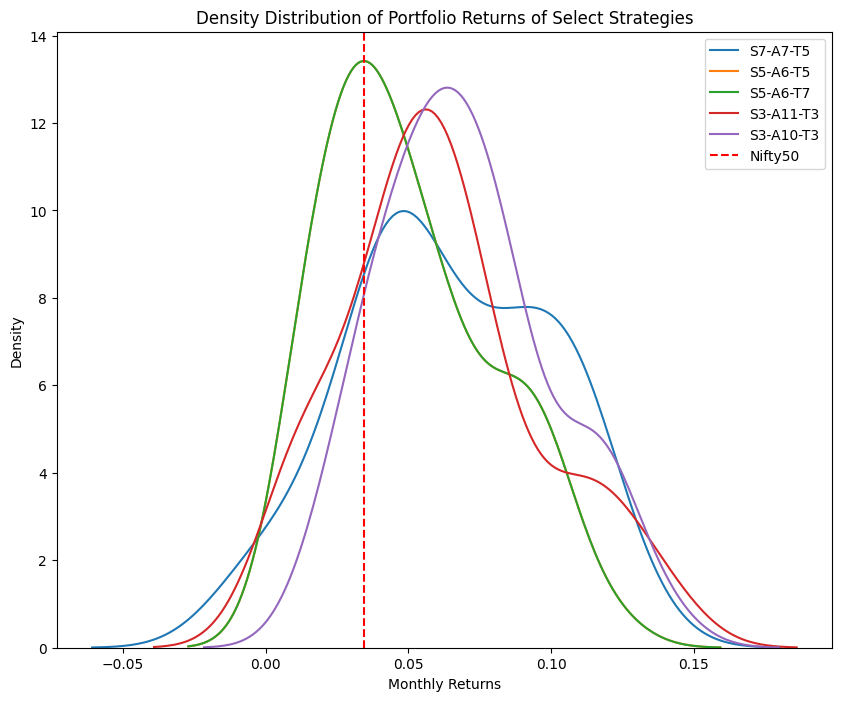

In [138]:
plt.figure(figsize=(10, 8))

super_super_strategies = []

for strategy, returns in strategy_sell_price_dict.items():

    if (sum(returns)/len(returns)) > nifty50:
        print(strategy, (sum(returns)/len(returns)))
        super_super_strategies.append(strategy)

        strategy = ast.literal_eval(strategy)
        ss = math.ceil(strategy[0]/2)
        wa = strategy[1]
        atf = strategy[2]
        label = f'S{ss}-A{wa}-T{atf}'
        sns.kdeplot(returns, label=label)

# Adding a vertical dotted line at 0.05        
plt.axvline(x=nifty50, color='r', linestyle='--', label='Nifty50')

# Adding titles and labels
title = 'Density Distribution of Portfolio Returns of Select Strategies'
plt.title(title)
plt.xlabel('Monthly Returns')
plt.ylabel('Density')
plt.legend()

# Save and display the plot
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

In [139]:
def calculate_app_add_cost(dict1, buy, sell):
    num_stocks = len(dict1)
    total_turnover = buy+sell
    extra_cost = (16*num_stocks) + (math.ceil(total_turnover/(num_stocks*1000))*num_stocks)
    return math.ceil(extra_cost)

def add_columns_for_extra_charges(df):
    
    portfolio_list = list(df['portfolio'])
    
    selling_amount_list = list(df['investment_value'])
    buying_amount_list = [100000.00] + selling_amount_list[:-1]
    extra_cost_list = []

    for i in range(len(portfolio_list)):
        portfolio_dict = ast.literal_eval(portfolio_list[i])
        buy = buying_amount_list[i]
        sell = selling_amount_list[i]
        extra_cost = calculate_app_add_cost(portfolio_dict, buy, sell)
        extra_cost_list.append(extra_cost)
    
    return_list = []
    for i in range(len(portfolio_list)):
        returns = (selling_amount_list[i]/buying_amount_list[i])
        return_list.append(returns)

    new_selling_list = []

    for i in range(len(portfolio_list)):
        if i == 0:
            new_sell = selling_amount_list[0] - extra_cost_list[0]
            new_selling_list.append(round(new_sell,2))
        else:
            new_sell = (new_selling_list[i-1]*return_list[i]) - extra_cost_list[i]
            new_selling_list.append(round(new_sell,2))
    
    df['after_rebalancing_cost'] = new_selling_list
    
    return df

def add_columns_for_extra_charges_2(df):
    
    portfolio_list = list(df['portfolio'])
    
    selling_amount_list = list(df['investment_value_2'])
    buying_amount_list = [100000.00] + selling_amount_list[:-1]
    extra_cost_list = []

    for i in range(len(portfolio_list)):
        portfolio_dict = ast.literal_eval(portfolio_list[i])
        buy = buying_amount_list[i]
        sell = selling_amount_list[i]
        extra_cost = calculate_app_add_cost(portfolio_dict, buy, sell)
        extra_cost_list.append(extra_cost)
    
    return_list = []
    for i in range(len(portfolio_list)):
        returns = (selling_amount_list[i]/buying_amount_list[i])
        return_list.append(returns)

    new_selling_list = []

    for i in range(len(portfolio_list)):
        if i == 0:
            new_sell = selling_amount_list[0] - extra_cost_list[0]
            new_selling_list.append(round(new_sell,2))
        else:
            new_sell = (new_selling_list[i-1]*return_list[i]) - extra_cost_list[i]
            new_selling_list.append(round(new_sell,2))
    
    df['after_rebalancing_cost_2'] = new_selling_list
    
    return df

In [140]:
value_lists_list = []

# for strategy in strategies_selected:
for strategy in super_super_strategies:
    strategy = ast.literal_eval(strategy)
    stock_selection_method = strategy[0]
    weight_allocation_method = strategy[1]
    backtesting_version = strategy[2]
    file_path = f'../backtesting_results/version_{backtesting_version}/strategy_{stock_selection_method}_{weight_allocation_method}.csv'

    df = pd.read_csv(file_path)

    df = add_columns_for_extra_charges(df)

    value_list = [100000.00] + list(df['after rebalancing cost'])

    value_lists_list.append(value_list)

In [141]:
quarterly_dates = [datetime(year, month, 1) for year in range(2020, 2024) for month in [1, 4, 7, 10]]
formatted_quarterly_dates = [date.strftime('%Y-%m-%d') for date in quarterly_dates]

backtesting_buying_dates_for_1q_hold = formatted_quarterly_dates

len(backtesting_buying_dates_for_1q_hold)

16

In [142]:
nifty_returns_1q_periods = []

for date in backtesting_buying_dates_for_1q_hold:
    buy_date = date
    sell_date = str(datetime.strptime(buy_date, '%Y-%m-%d') + relativedelta(months=3))[:10]

    adjusted_buy_date = nifty50_data[nifty50_data.index >= buy_date].index[0]
    try:
        adjusted_sell_date = nifty50_data[nifty50_data.index >= sell_date].index[0]
    except:
        adjusted_sell_date = nifty50_data[nifty50_data.index <= sell_date].index[-1]

    buy_price = nifty50_data[nifty50_data.index == adjusted_buy_date].values[0][0]
    sell_price = nifty50_data[nifty50_data.index == adjusted_sell_date].values[0][0]

    returns = (sell_price/buy_price)-1

    nifty_returns_1q_periods.append(returns)

In [143]:
nifty_investment_values = [100000.00]

for returns in nifty_returns_1q_periods:
    nifty_investment_values.append(round(nifty_investment_values[-1]*(1+returns),2))

len(nifty_investment_values), nifty_investment_values

(17,
 [100000.0,
  67751.28,
  85615.02,
  93715.99,
  115070.8,
  122038.58,
  128709.22,
  143911.77,
  144680.48,
  145047.81,
  129300.64,
  138619.74,
  149373.69,
  142811.83,
  158609.08,
  160301.67,
  178468.31])

In [144]:
for i in quarterly_dates:
    print(str(i)[:7])

2020-01
2020-04
2020-07
2020-10
2021-01
2021-04
2021-07
2021-10
2022-01
2022-04
2022-07
2022-10
2023-01
2023-04
2023-07
2023-10


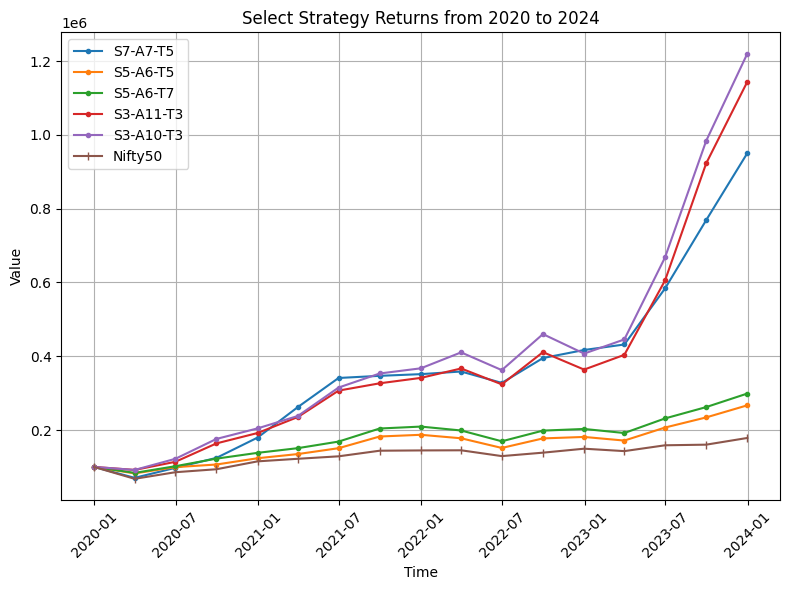

In [145]:
data_lists = value_lists_list

quarterly_dates = pd.date_range(start='2019-10-01', periods=17, freq='Q')
monthly_dates = pd.date_range(start='2019-12-01', periods=49, freq='M')

# Plotting all sub-lists on the same plot
plt.figure(figsize=(8, 6))

for data in data_lists:
    if len(data) == 17:  # If data length matches quarterly data
        plt.plot(quarterly_dates, data, marker='.', linestyle='-')
    elif len(data) == 49:  # If data length matches monthly data
        plt.plot(monthly_dates, data, marker='.', linestyle='-')

plt.plot(quarterly_dates, nifty_investment_values, marker='|', linestyle='-')

title = 'Select Strategy Returns from 2020 to 2024'
plt.title(title)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['S7-A7-T5','S5-A6-T5','S5-A6-T7','S3-A11-T3','S3-A10-T3','Nifty50'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

In [146]:
strategy_performance_dict = {}

for s in super_super_strategies:
    strategy_performance_dict[s] = super_strategies_performance_dict[s]

strategy_performance_dict

{'(13, 7, 5)': [{'buy_date': '2023-10-03 00:00:00',
   'sell_date': '2024-01-03 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'SUZLON.NS': 0.125,
    'BSE.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'IRFC.NS': 0.125,
    'RESPONIND.NS': 0.125},
   'sell_price': 125930.22},
  {'buy_date': '2023-10-04 00:00:00',
   'sell_date': '2024-01-04 00:00:00',
   'portfolio': {'GET&D.NS': 0.125,
    'SUZLON.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125,
    'TITAGARH.NS': 0.125},
   'sell_price': 137392.35},
  {'buy_date': '2023-10-05 00:00:00',
   'sell_date': '2024-01-05 00:00:00',
   'portfolio': {'SUZLON.NS': 0.125,
    'GET&D.NS': 0.125,
    'JWL.NS': 0.125,
    'MAZDOCK.NS': 0.125,
    'HBLPOWER.NS': 0.125,
    'TITAGARH.NS': 0.125,
    'BSE.NS': 0.125,
    'IRFC.NS': 0.125},
   'sell_price': 137018.31},
  {'buy_date': '2023-10-06 00:00:00',
   'sell_date': '2024-0

(13, 7, 5) 0.0647
(9, 6, 5) 0.0822
(9, 6, 7) 0.0822
(5, 11, 3) 0.0084
(5, 10, 3) 0.0181


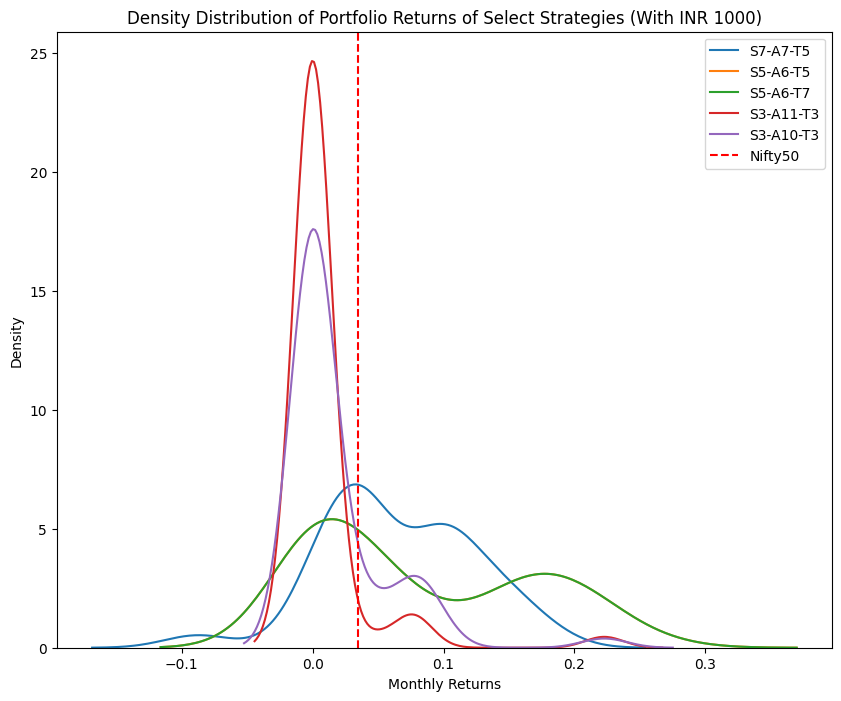

(13, 7, 5) 0.0614
(9, 6, 5) 0.0523
(9, 6, 7) 0.0523
(5, 11, 3) 0.0461
(5, 10, 3) 0.0536


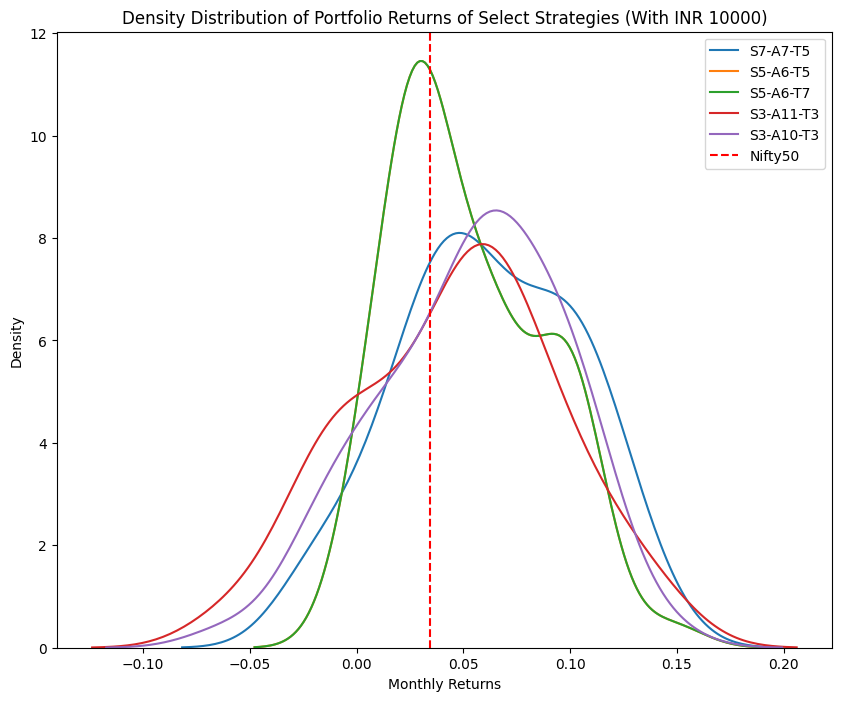

(13, 7, 5) 0.0633
(9, 6, 5) 0.0491
(9, 6, 7) 0.0491
(5, 11, 3) 0.0594
(5, 10, 3) 0.068


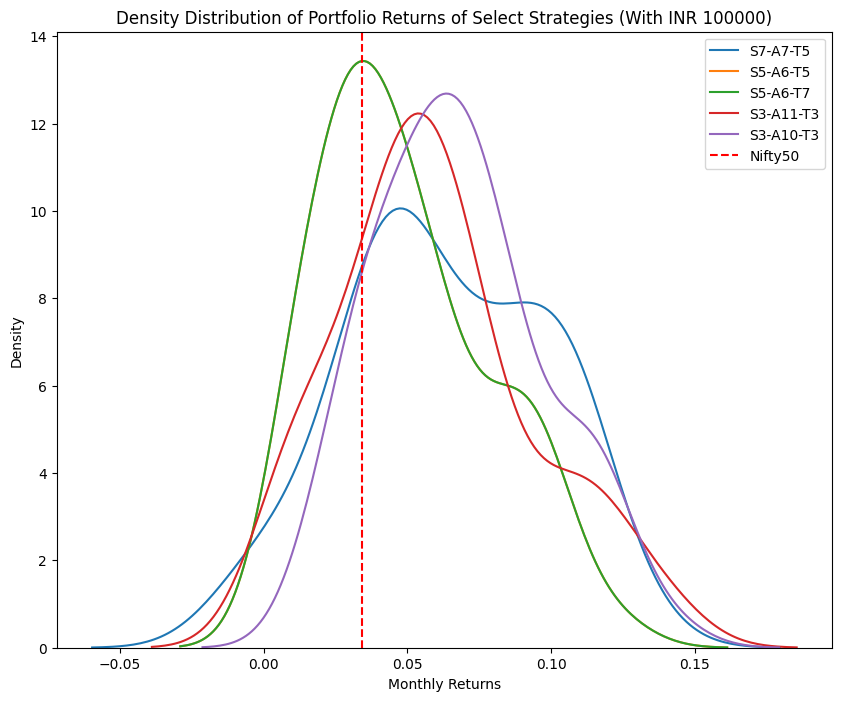

(13, 7, 5) 0.0639
(9, 6, 5) 0.0502
(9, 6, 7) 0.0502
(5, 11, 3) 0.0611
(5, 10, 3) 0.0697


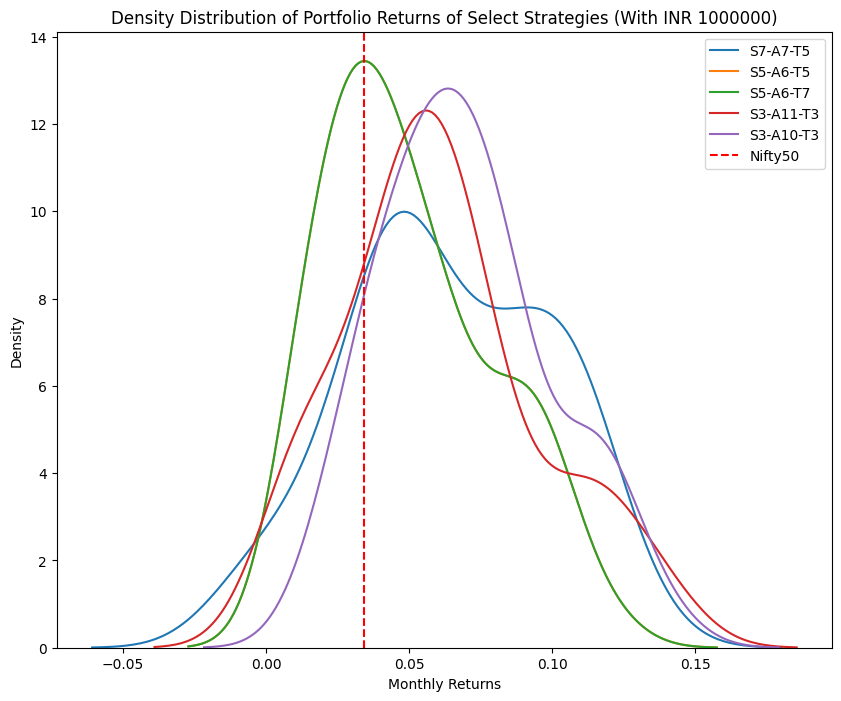

In [147]:
for amount in [1000, 10000, 100000, 1000000]:
    
    plt.figure(figsize=(10, 8))

    for strategy, results in strategy_performance_dict.items():
        for result in results:
            buying_date = result['buy_date'][:10]
            selling_date = result['sell_date'][:10]
            portfolio_weights = result['portfolio']

            adjusted_buy_date = all_stocks_df[all_stocks_df.index <= buying_date].index[-1]
            adjusted_sell_date = all_stocks_df[all_stocks_df.index <= selling_date].index[-1]
        
            final_shares, price_dict, actual_investment = calculate_shares_to_buy_with_prices(portfolio_weights, all_stocks_df, adjusted_buy_date, amount, True)
            
            profit = 0
            for stock_symbol, number_of_shares in final_shares.items():
                buy_amount = (all_stocks_df[stock_symbol].loc[adjusted_buy_date] * number_of_shares)
                sell_amount = (all_stocks_df[stock_symbol].loc[adjusted_sell_date] * number_of_shares)
                profit += sell_amount-buy_amount
            
            result['sell_price'] = amount + profit

    strategy_sell_price_dict_2 = {}
    for strategy, portfolios in strategy_performance_dict.items():
        strategy_sell_price_dict_2[strategy] = []
        if len(portfolios) == 65:
            for portfolio in portfolios:
                strategy_sell_price_dict_2[strategy].append(round((portfolio['sell_price']/amount)-1,4))
        else:
            for portfolio in portfolios:
                return_quarterly = (portfolio['sell_price']/amount)-1
                strategy_sell_price_dict_2[strategy].append(round(((1+return_quarterly)**(1/3))-1,4))

    for k,v in strategy_sell_price_dict_2.items():
        print(k, round(sum(v)/len(v),4))

    for strategy, returns in strategy_sell_price_dict_2.items():
        strategy = ast.literal_eval(strategy)
        ss = math.ceil(strategy[0]/2)
        wa = strategy[1]
        atf = strategy[2]
        label = f'S{ss}-A{wa}-T{atf}'
        sns.kdeplot(returns, label=label)

    # Adding a vertical dotted line at 0.05
    plt.axvline(x=nifty50, color='r', linestyle='--', label='Nifty50')
    # Adding titles and labels
    title = f'Density Distribution of Portfolio Returns of Select Strategies (With INR {amount})'
    plt.title(title)
    plt.xlabel('Monthly Returns')
    plt.ylabel('Density')
    plt.legend()

    # Save and display the plot
    plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
    plt.show()

In [148]:
super_super_strategies

['(13, 7, 5)', '(9, 6, 5)', '(9, 6, 7)', '(5, 11, 3)', '(5, 10, 3)']

In [149]:
value_lists_list_2 = []

for strategy in super_super_strategies:

    strategy = ast.literal_eval(strategy)
    
    init_invt_amt_li = []
    initial_investment = 100000

    stock_selection_method = strategy[0]
    weight_allocation_method = strategy[1]
    backtesting_version = strategy[2]
    file_path = f'../backtesting_results/version_{backtesting_version}/strategy_{stock_selection_method}_{weight_allocation_method}.csv'

    df = pd.read_csv(file_path)

    for i in range(len(df)):
        adjusted_buy_date = all_stocks_df[all_stocks_df.index <= df.iloc[i]['buy_date']].index[-1]
        adjusted_sell_date = all_stocks_df[all_stocks_df.index <= df.iloc[i]['sell_date']].index[-1]
        portfolio_weights = ast.literal_eval(df.iloc[i]['portfolio'])

        final_shares, price_dict, actual_investment = calculate_shares_to_buy_with_prices(portfolio_weights, all_stocks_df, adjusted_buy_date, initial_investment, True)

        profit = 0
        for stock_symbol, number_of_shares in final_shares.items():
            buy_amount = (all_stocks_df[stock_symbol].loc[adjusted_buy_date] * number_of_shares)
            sell_amount = (all_stocks_df[stock_symbol].loc[adjusted_sell_date] * number_of_shares)
            profit += sell_amount-buy_amount

        initial_investment += profit
        init_invt_amt_li.append(round(initial_investment,2))
    
    df['investment_value_2'] = init_invt_amt_li
    
    df = add_columns_for_extra_charges_2(df)

    value_list = [100000.00] + list(df['after_rebalancing_cost_2'])

    value_lists_list_2.append(value_list)

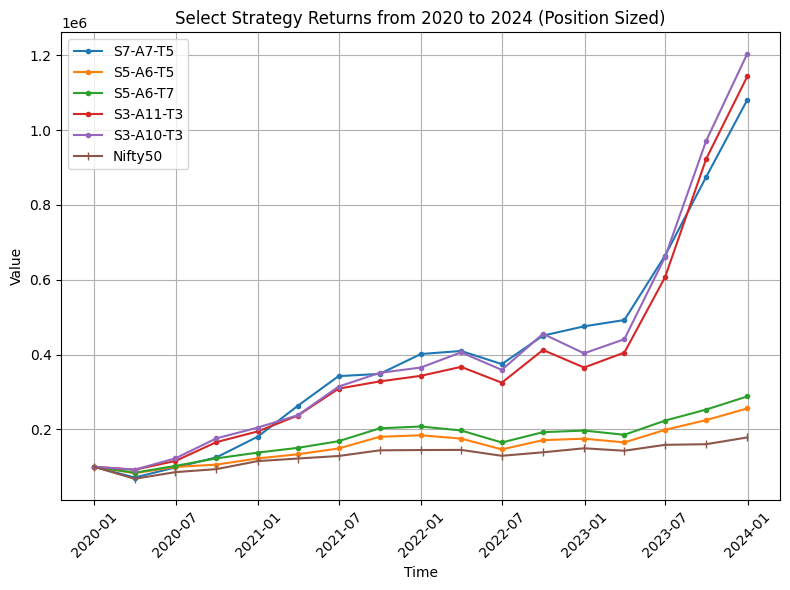

In [150]:
data_lists = value_lists_list_2

quarterly_dates = pd.date_range(start='2019-10-01', periods=17, freq='Q')
monthly_dates = pd.date_range(start='2019-12-01', periods=49, freq='M')

# Plotting all sub-lists on the same plot
plt.figure(figsize=(8, 6))

for data in data_lists:
    if len(data) == 17:  # If data length matches quarterly data
        plt.plot(quarterly_dates, data, marker='.', linestyle='-')
    elif len(data) == 49:  # If data length matches monthly data
        plt.plot(monthly_dates, data, marker='.', linestyle='-')

plt.plot(quarterly_dates, nifty_investment_values, marker='|', linestyle='-')

title = 'Select Strategy Returns from 2020 to 2024 (Position Sized)'
plt.title(title)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['S7-A7-T5','S5-A6-T5','S5-A6-T7','S3-A11-T3','S3-A10-T3','Nifty50'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

In [151]:
s = 0

for i in range(len(value_lists_list)):
    ps = value_lists_list_2[i][-1]
    nm = value_lists_list[i][-1]
    s += (ps/nm)-1
    print((ps/nm)-1)

print(s/5)

0.13773100543148797
-0.041252467661533565
-0.03604947209483511
3.322090011970147e-07
-0.012612733352393546
0.00956333290634539


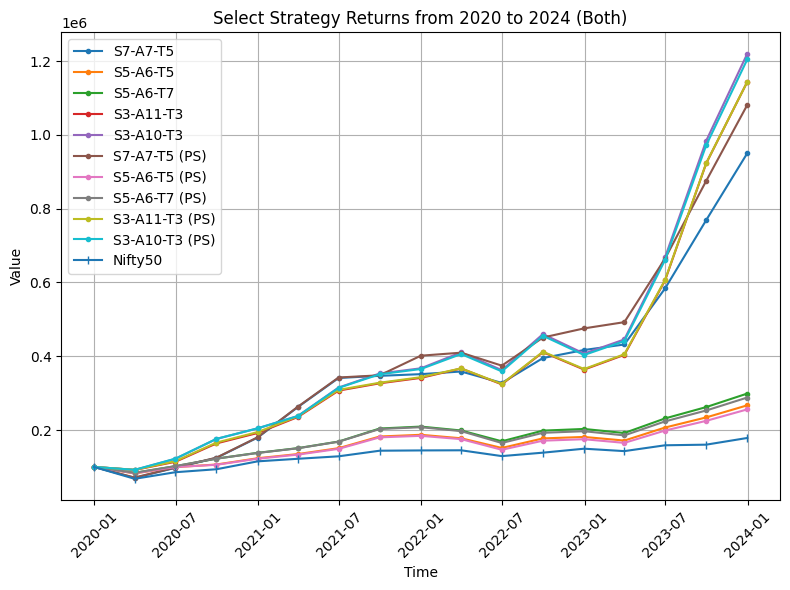

In [152]:
data_lists = value_lists_list + value_lists_list_2

quarterly_dates = pd.date_range(start='2019-10-01', periods=17, freq='Q')
monthly_dates = pd.date_range(start='2019-12-01', periods=49, freq='M')

# Plotting all sub-lists on the same plot
plt.figure(figsize=(8, 6))

for data in data_lists:
    if len(data) == 17:  # If data length matches quarterly data
        plt.plot(quarterly_dates, data, marker='.', linestyle='-')
    elif len(data) == 49:  # If data length matches monthly data
        plt.plot(monthly_dates, data, marker='.', linestyle='-')

plt.plot(quarterly_dates, nifty_investment_values, marker='|', linestyle='-')

title = 'Select Strategy Returns from 2020 to 2024 (Both)'
plt.title(title)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['S7-A7-T5','S5-A6-T5','S5-A6-T7','S3-A11-T3','S3-A10-T3', 'S7-A7-T5 (PS)','S5-A6-T5 (PS)','S5-A6-T7 (PS)','S3-A11-T3 (PS)','S3-A10-T3 (PS)', 'Nifty50'])
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../backtesting_results/graphs/{title}.png', dpi=300)
plt.show()

In [153]:
for list_ in value_lists_list:
    return_4y = round(list_[-1]/list_[0],2)
    annualized_return = round((return_4y**(1/4))-1,4)
    print(annualized_return)

0.7556
0.2783
0.315
0.8391
0.8689


In [154]:
for list_ in value_lists_list_2:
    return_4y = round(list_[-1]/list_[0],2)
    annualized_return = round((return_4y**(1/4))-1,4)
    print(annualized_return)

0.8132
0.2649
0.3027
0.8391
0.8631


In [155]:
nifty_investment_values

[100000.0,
 67751.28,
 85615.02,
 93715.99,
 115070.8,
 122038.58,
 128709.22,
 143911.77,
 144680.48,
 145047.81,
 129300.64,
 138619.74,
 149373.69,
 142811.83,
 158609.08,
 160301.67,
 178468.31]

In [156]:
return_4y = round(nifty_investment_values[-1]/nifty_investment_values[0],2)
annualized_return = round((return_4y**(1/4))-1,4)
annualized_return

0.1551

In [157]:
df_backup

,Strategy_Combination,Stock_Selection_Method,Weight_Allocation_Method,Total_Return,CAGR_4Y,CAGR_3Y,CAGR_2Y,CAGR_1Y,Positive_Return_Count,Negative_Return_Count,...,Analysis_Time_Frame_Combinations,Rebalance,Min_CAGR,Max_CAGR,Diff_CAGR,Min_Variance,Max_Variance,Diff_Variance,CAGR_analysis,Variance_analysis
0,7_8_1,S7,A8,10.69,0.81,0.68,0.56,1.24,12,4,...,T1,3m,0.56,1.24,0.68,0.0305,0.0815,0.0510,3.29,0.2355
9,7_9_1,S7,A9,7.61,0.66,0.58,0.58,1.18,11,5,...,T1,3m,0.58,1.18,0.60,0.0324,0.0670,0.0346,3.00,0.2132
10,8_10_1,S8,A10,10.50,0.80,0.50,0.43,1.14,33,15,...,T1,1m,0.43,1.14,0.71,0.0141,0.0811,0.0670,2.87,0.1638
11,6_9_1,S6,A9,6.25,0.58,0.36,0.25,1.17,31,17,...,T1,1m,0.25,1.17,0.92,0.0333,0.0616,0.0283,2.36,0.1791
16,6_8_1,S6,A8,6.15,0.57,0.43,0.31,1.05,31,17,...,T1,1m,0.31,1.05,0.74,0.0240,0.0386,0.0146,2.36,0.1220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,1_10_10,S1,A10,4.39,0.45,0.40,0.42,0.80,11,5,...,T10,3m,0.40,0.80,0.40,0.0377,0.0911,0.0534,2.07,0.2278
170,1_11_10,S1,A11,4.35,0.44,0.42,0.40,0.74,10,6,...,T10,3m,0.40,0.74,0.34,0.0331,0.0769,0.0438,2.00,0.1931
171,8_3_10,S8,A3,5.04,0.50,0.20,0.01,0.63,26,22,...,T10,1m,0.01,0.63,0.62,0.0525,0.3413,0.2888,1.34,0.5169
174,6_7_10,S6,A7,4.50,0.46,0.45,0.33,0.23,34,14,...,T10,1m,0.23,0.46,0.23,0.0073,0.0251,0.0178,1.47,0.0527


In [158]:
abcd = ['7_7_5','5_6_5','5_6_7','3_11_3','3_10_3']
        
df_selected = df_backup[df_backup['Strategy_Combination'].isin(abcd)].sort_values(by='Strategy_Combination')[['Strategy_Combination','CAGR_4Y','CAGR_3Y','CAGR_2Y','CAGR_1Y','Variance_4Y','Variance_3Y','Variance_2Y','Variance_1Y','Success_Rate','Rebalance']]

df_selected['Strategy_Combination'] = pd.Categorical(df_selected['Strategy_Combination'], categories=abcd, ordered=True)

df_selected_sorted = df_selected.sort_values('Strategy_Combination')

df_selected_sorted['Strategy_Combination'] = ['Strategy 1','Strategy 2','Strategy 3','Strategy 4','Strategy 5']

df_selected_sorted['CAGR_4Y'] = ((df_selected_sorted['CAGR_4Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['CAGR_3Y'] = ((df_selected_sorted['CAGR_3Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['CAGR_2Y'] = ((df_selected_sorted['CAGR_2Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['CAGR_1Y'] = ((df_selected_sorted['CAGR_1Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['Variance_4Y'] = ((df_selected_sorted['Variance_4Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['Variance_3Y'] = ((df_selected_sorted['Variance_3Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['Variance_2Y'] = ((df_selected_sorted['Variance_2Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['Variance_1Y'] = ((df_selected_sorted['Variance_1Y'] * 100).round(2)).astype(str) + '%'
df_selected_sorted['Success_Rate'] = ((df_selected_sorted['Success_Rate'] * 100).round(2)).astype(str) + '%'

columns = ['Strategy','4Y CAGR', '3Y CAGR', '2Y CAGR', '1Y CAGR', '4Y Variance', '3Y Variance', '2Y Variance', '1Y Variance', 'Success Rate', 'Rebalancing Period']

df_selected_sorted.columns = columns

df_selected_sorted['Combination Code'] = ['S7-A7-T5', 'S5-A6-T5', 'S5-A6-T7', 'S3-A11-T3', 'S3-A10-T3']

new_order = ['Strategy', 'Combination Code', 'Success Rate', '1Y CAGR', '2Y CAGR', '3Y CAGR', '4Y CAGR', '1Y Variance', '2Y Variance', '3Y Variance', '4Y Variance', 'Rebalancing Period']

df_selected_sorted = df_selected_sorted[new_order]

df_selected_sorted.to_csv('../data/backtesting_stats.csv', index=False)

df_selected_sorted

,Strategy,Combination Code,Success Rate,1Y CAGR,2Y CAGR,3Y CAGR,4Y CAGR,1Y Variance,2Y Variance,3Y Variance,4Y Variance,Rebalancing Period
149,Strategy 1,S7-A7-T5,88.0%,128.0%,64.0%,74.0%,76.0%,2.0%,2.48%,2.98%,4.52%,3m
36,Strategy 2,S5-A6-T5,75.0%,47.0%,19.0%,29.0%,28.0%,1.25%,1.64%,1.28%,1.52%,3m
36,Strategy 3,S5-A6-T7,75.0%,47.0%,19.0%,29.0%,31.0%,1.25%,1.64%,1.29%,1.57%,3m
77,Strategy 4,S3-A11-T3,81.0%,214.0%,83.0%,81.0%,84.0%,4.08%,6.04%,4.29%,4.08%,3m
83,Strategy 5,S3-A10-T3,81.0%,200.0%,82.0%,81.0%,87.0%,3.75%,5.51%,3.91%,3.93%,3m


In [159]:
columns = ['Strategy', 'Combination Code', 'Average Monthly Returns', 'Success Rate']

df_new = pd.DataFrame(columns=columns)

values = [
    ['Strategy 1', 'S7-A7-T5', '6.39%', '96.61%'],
    ['Strategy 2', 'S5-A6-T5', '5.03%', '100.00%'],
    ['Strategy 3', 'S5-A6-T7', '5.03%', '100.00%'],
    ['Strategy 4', 'S3-A11-T3', '6.12%', '100.00%'],
    ['Strategy 5', 'S3-A10-T3', '6.98%', '100.00%']
]

for row in values:
    df_new = df_new.append(pd.Series(row, index=columns), ignore_index=True)

df_new.to_csv('../data/livetesting_stats.csv', index=False)

df_new

,Strategy,Combination Code,Average Monthly Returns,Success Rate
0,Strategy 1,S7-A7-T5,6.39%,96.61%
1,Strategy 2,S5-A6-T5,5.03%,100.00%
2,Strategy 3,S5-A6-T7,5.03%,100.00%
3,Strategy 4,S3-A11-T3,6.12%,100.00%
4,Strategy 5,S3-A10-T3,6.98%,100.00%


In [160]:
df_results = pd.DataFrame(columns=['Dates', 'Strategy 1', 'Strategy 2', 'Strategy 3', 'Strategy 4', 'Strategy 5', 'NIFTY 50'])

column1 = quarterly_dates
column2 = value_lists_list_2[0]
column3 = value_lists_list_2[1]
column4 = value_lists_list_2[2]
column5 = value_lists_list_2[3]
column6 = value_lists_list_2[4]
column7 = nifty_investment_values

df_results['Dates'] = column1
df_results['Strategy 1'] = column2
df_results['Strategy 2'] = column3
df_results['Strategy 3'] = column4
df_results['Strategy 4'] = column5
df_results['Strategy 5'] = column6
df_results['NIFTY 50'] = column7

df_results = df_results.set_index(keys='Dates')

df_results

,Strategy 1,Strategy 2,Strategy 3,Strategy 4,Strategy 5,NIFTY 50
Dates,,,,,,
2019-12-31,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
2020-03-31,71189.67,82774.78,84066.06,92169.60,92169.60,67751.28
2020-06-30,98220.90,99621.78,102259.10,115410.99,122353.51,85615.02
2020-09-30,125143.57,105745.49,122398.40,165951.59,176014.11,93715.99
2020-12-31,180276.91,122296.06,137810.14,194409.61,204614.62,115070.80
2021-03-31,263144.55,133359.64,150532.25,237008.47,237780.97,122038.58
2021-06-30,342297.81,148916.45,168347.42,308815.25,314268.14,128709.22
2021-09-30,348292.13,180119.75,202720.52,328173.63,351101.78,143911.77
2021-12-31,401429.47,184228.70,207656.71,343145.89,365291.85,144680.48


In [161]:
df_results.to_csv('../data/selected_strategies_results.csv')

In [162]:
def get_selected_strategies_results():
    data = pd.read_csv('../data/selected_strategies_results.csv')
    return data

data = get_selected_strategies_results()
data = data.set_index('Dates')
data

,Strategy 1,Strategy 2,Strategy 3,Strategy 4,Strategy 5,NIFTY 50
Dates,,,,,,
2019-12-31,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
2020-03-31,71189.67,82774.78,84066.06,92169.60,92169.60,67751.28
2020-06-30,98220.90,99621.78,102259.10,115410.99,122353.51,85615.02
2020-09-30,125143.57,105745.49,122398.40,165951.59,176014.11,93715.99
2020-12-31,180276.91,122296.06,137810.14,194409.61,204614.62,115070.80
2021-03-31,263144.55,133359.64,150532.25,237008.47,237780.97,122038.58
2021-06-30,342297.81,148916.45,168347.42,308815.25,314268.14,128709.22
2021-09-30,348292.13,180119.75,202720.52,328173.63,351101.78,143911.77
2021-12-31,401429.47,184228.70,207656.71,343145.89,365291.85,144680.48


In [163]:
df_density_plot = pd.DataFrame(columns=['Date','Strategy 1','Strategy 2','Strategy 3','Strategy 4','Strategy 5'])

df_density_plot['Date'] = backtesting_buying_dates_for_1q_hold_

i = 1
for strategy, returns in strategy_sell_price_dict.items():
    if (sum(returns)/len(returns)) > nifty50:
        # print(strategy, (sum(returns)/len(returns)))
        super_super_strategies.append(strategy)

        strategy = ast.literal_eval(strategy)
        ss = math.ceil(strategy[0]/2)
        wa = strategy[1]
        atf = strategy[2]
        label = f'S{ss}-A{wa}-T{atf}'
        df_density_plot[f'Strategy {i}'] = returns
        i += 1

df_density_plot.to_csv('../data/density_plot_data.csv', index=False)

df_density_plot

,Date,Strategy 1,Strategy 2,Strategy 3,Strategy 4,Strategy 5
0,2023-10-03,0.0799,0.0313,0.0313,0.0688,0.0698
1,2023-10-04,0.1117,0.0346,0.0346,0.0435,0.0596
2,2023-10-05,0.1107,0.0330,0.0330,0.0493,0.0551
3,2023-10-06,0.1168,0.0353,0.0353,0.0799,0.0799
4,2023-10-09,0.1333,0.0460,0.0460,0.0846,0.0846
5,2023-10-10,0.1151,0.0451,0.0451,0.0857,0.0857
6,2023-10-11,0.1119,0.0724,0.0724,0.0636,0.0681
7,2023-10-12,0.1173,0.0413,0.0413,0.0551,0.0551
8,2023-10-13,0.1011,0.0564,0.0564,0.0535,0.0751
9,2023-10-16,0.0863,0.0373,0.0373,0.0725,0.0619


In [164]:
df_density_plot['Strategy 5'].mean()

0.06985762711864406

In [165]:
stock_selection_methods_to_consider = ['S3','S5','S7']
weight_allocation_methods_to_consider = ['A6','A7','A10','A11']
backtesting_versions_to_consider = ['T3','T5','T7']

stock_selection_methods_to_consider, weight_allocation_methods_to_consider, backtesting_versions_to_consider

(['S3', 'S5', 'S7'], ['A6', 'A7', 'A10', 'A11'], ['T3', 'T5', 'T7'])

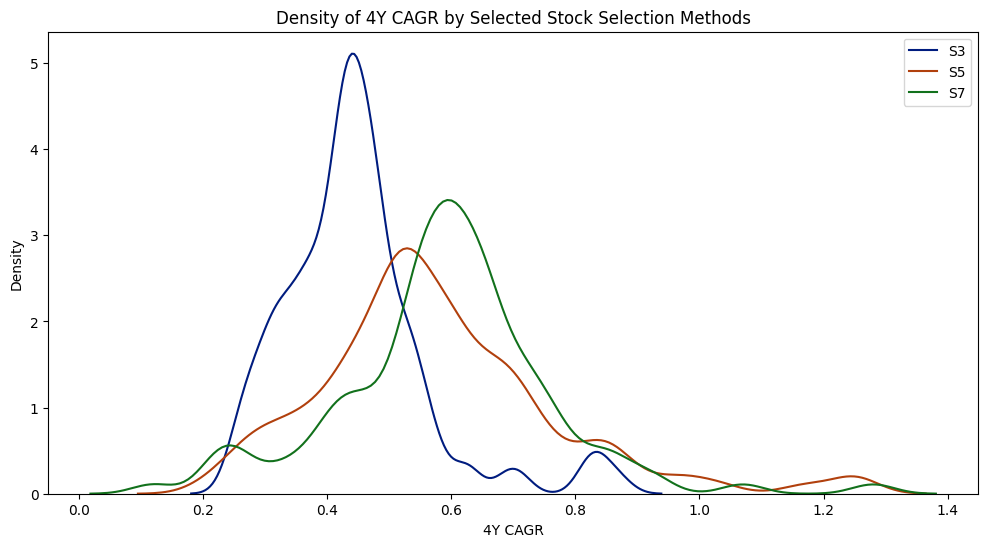

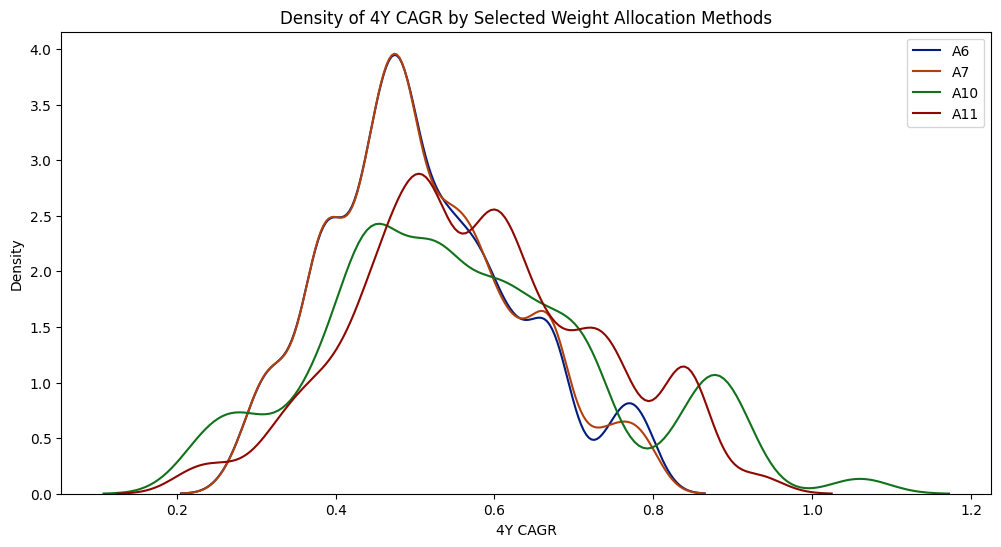

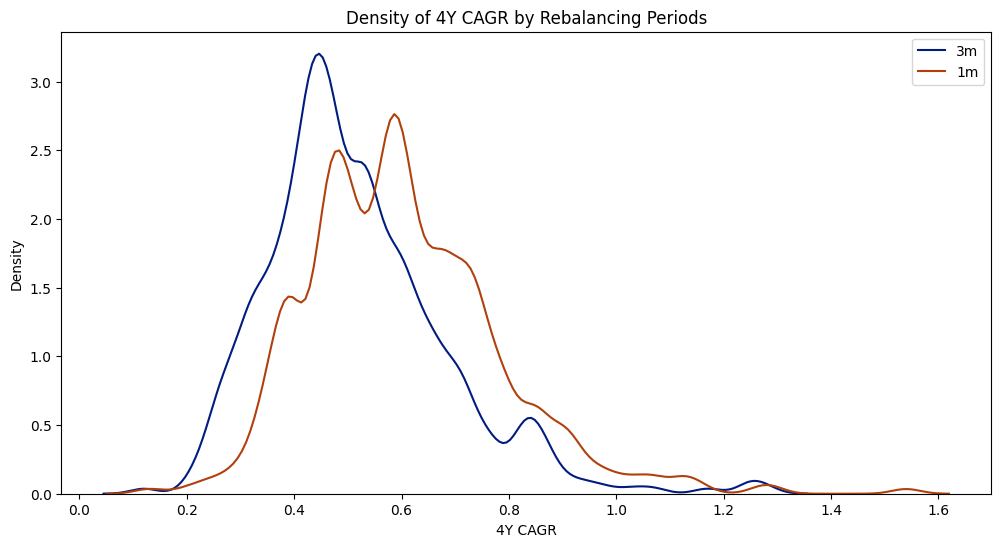

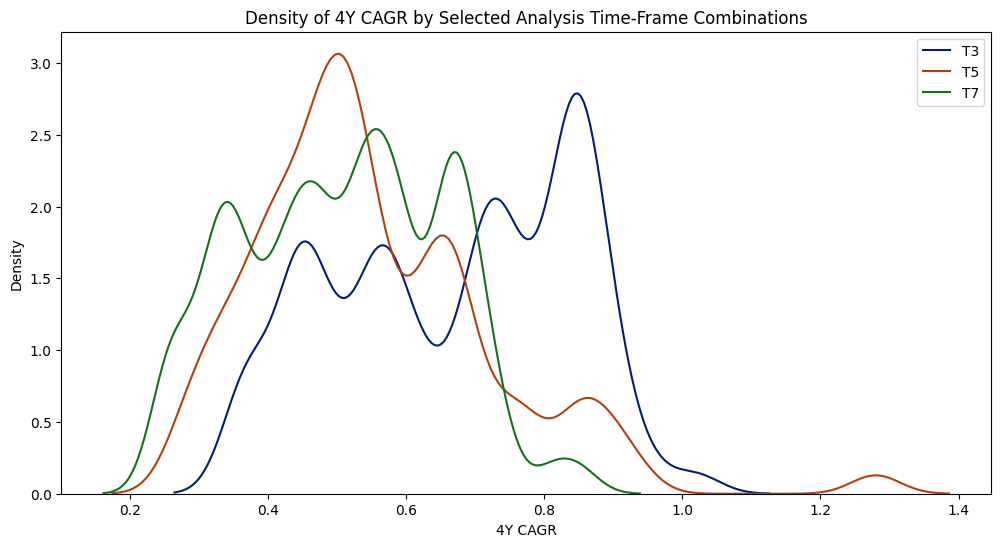

In [166]:
plot_density_curves_for_comparison(df_backup, stock_selection_methods_to_consider, 'CAGR_4Y', 'Density of 4Y CAGR by Selected Stock Selection Methods', '4Y CAGR', 'Density', 'Stock_Selection_Method')
plot_density_curves_for_comparison(df_backup, weight_allocation_methods_to_consider, 'CAGR_4Y', 'Density of 4Y CAGR by Selected Weight Allocation Methods', '4Y CAGR', 'Density', 'Weight_Allocation_Method')
plot_density_curves_for_comparison(df_backup, df_backup['Rebalance'].unique(), 'CAGR_4Y', 'Density of 4Y CAGR by Rebalancing Periods', '4Y CAGR', 'Density', 'Rebalance')
plot_density_curves_for_comparison(df_backup, backtesting_versions_to_consider, 'CAGR_4Y', 'Density of 4Y CAGR by Selected Analysis Time-Frame Combinations', '4Y CAGR', 'Density', 'Analysis_Time_Frame_Combinations')

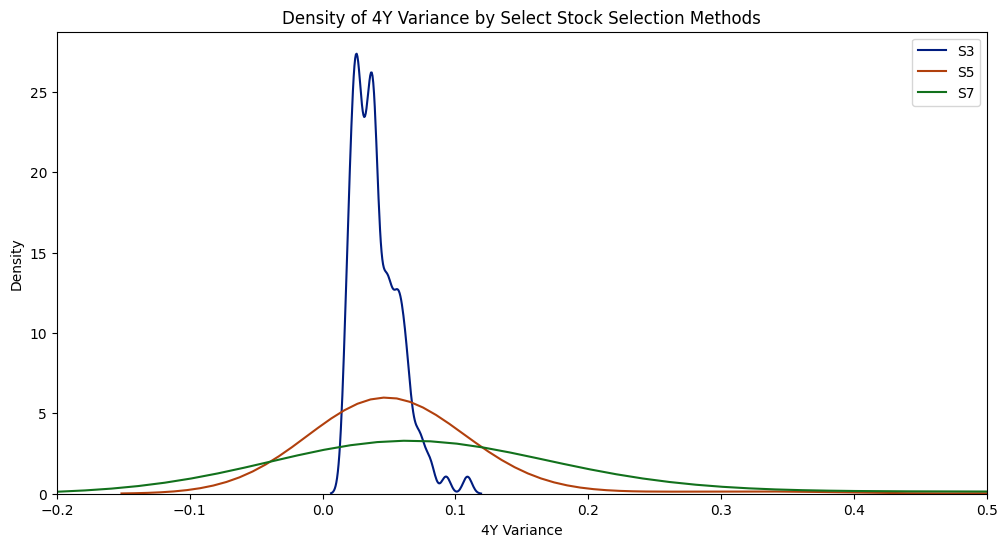

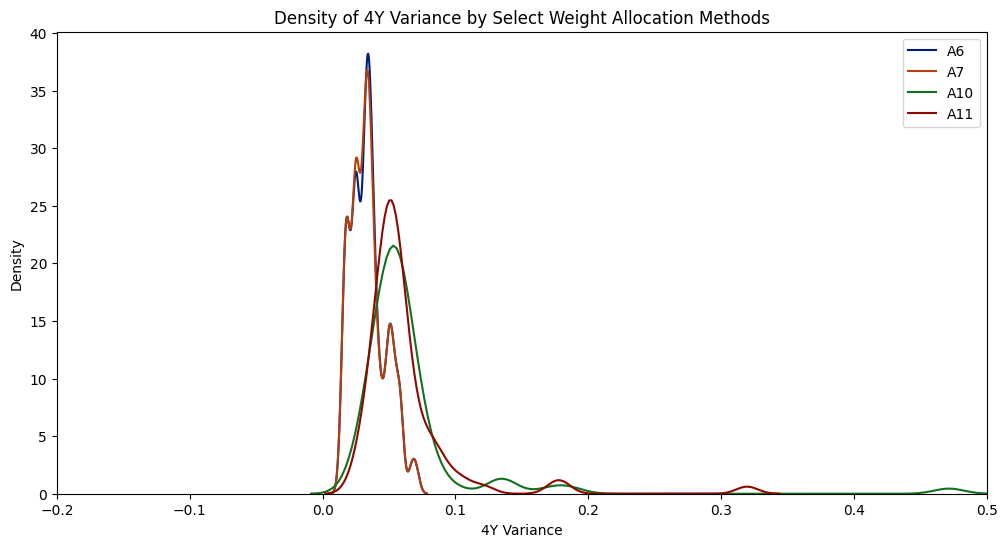

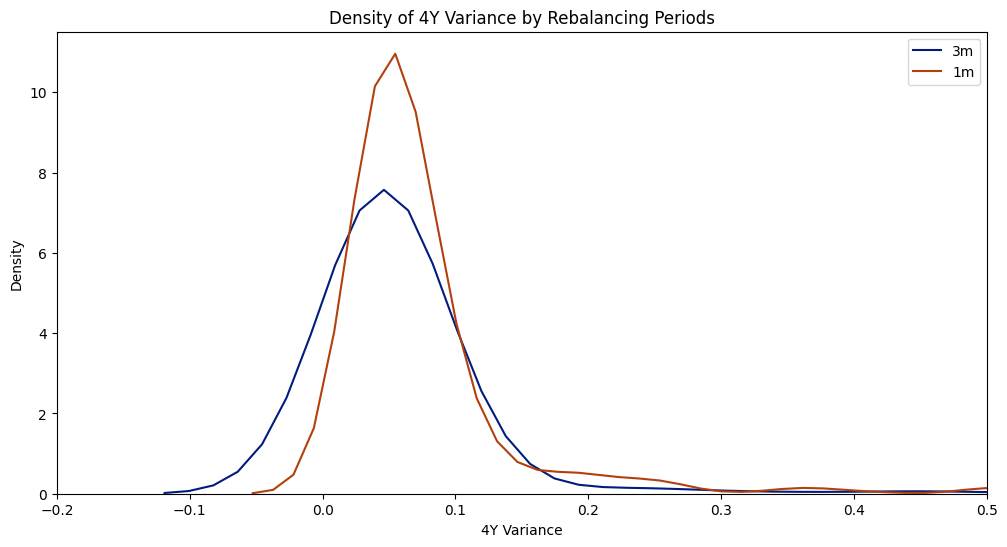

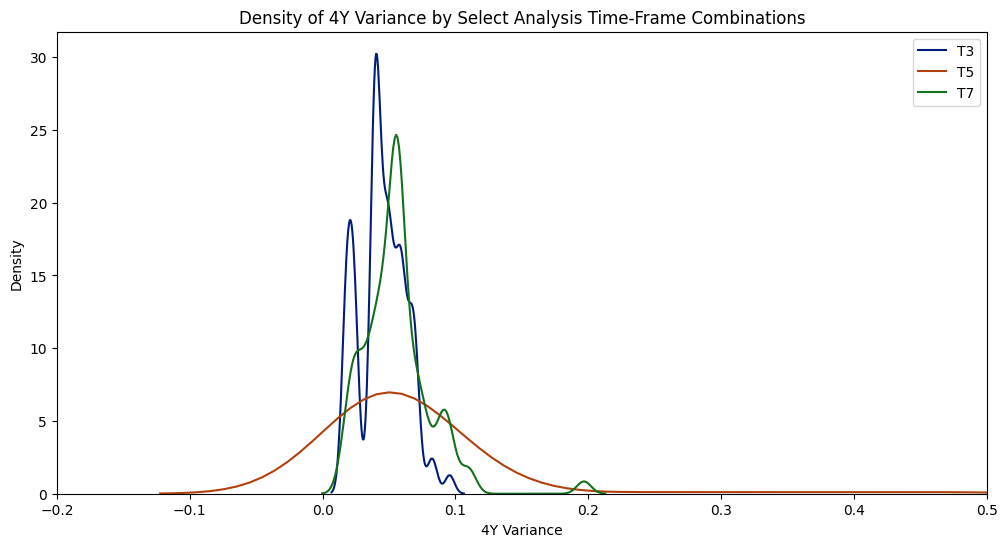

In [167]:
plot_density_curves_for_comparison(df_backup, stock_selection_methods_to_consider, 'Variance_4Y', 'Density of 4Y Variance by Select Stock Selection Methods', '4Y Variance', 'Density', 'Stock_Selection_Method')
plot_density_curves_for_comparison(df_backup, weight_allocation_methods_to_consider, 'Variance_4Y', 'Density of 4Y Variance by Select Weight Allocation Methods', '4Y Variance', 'Density', 'Weight_Allocation_Method')
plot_density_curves_for_comparison(df_backup, df_backup['Rebalance'].unique(), 'Variance_4Y', 'Density of 4Y Variance by Rebalancing Periods', '4Y Variance', 'Density', 'Rebalance')
plot_density_curves_for_comparison(df_backup, backtesting_versions_to_consider, 'Variance_4Y', 'Density of 4Y Variance by Select Analysis Time-Frame Combinations', '4Y Variance', 'Density', 'Analysis_Time_Frame_Combinations')

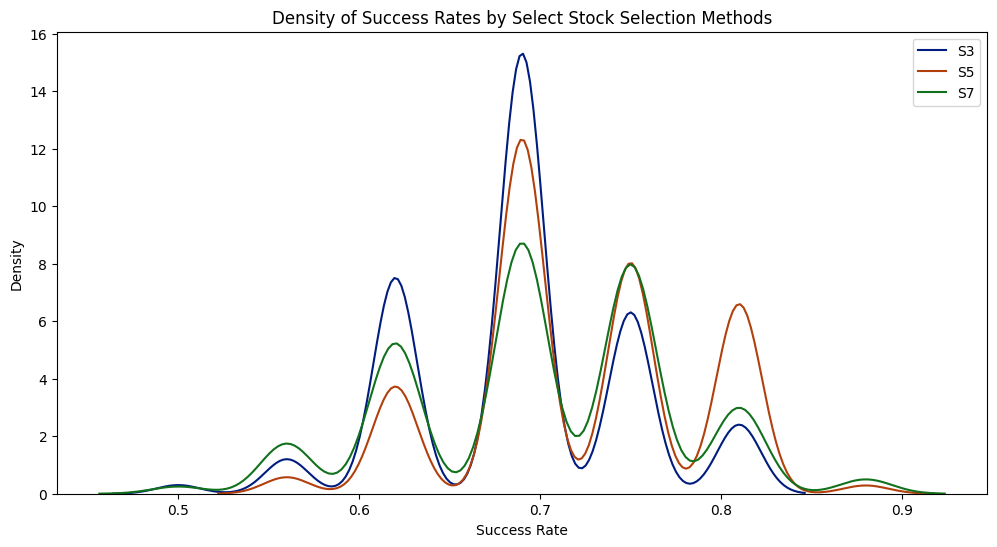

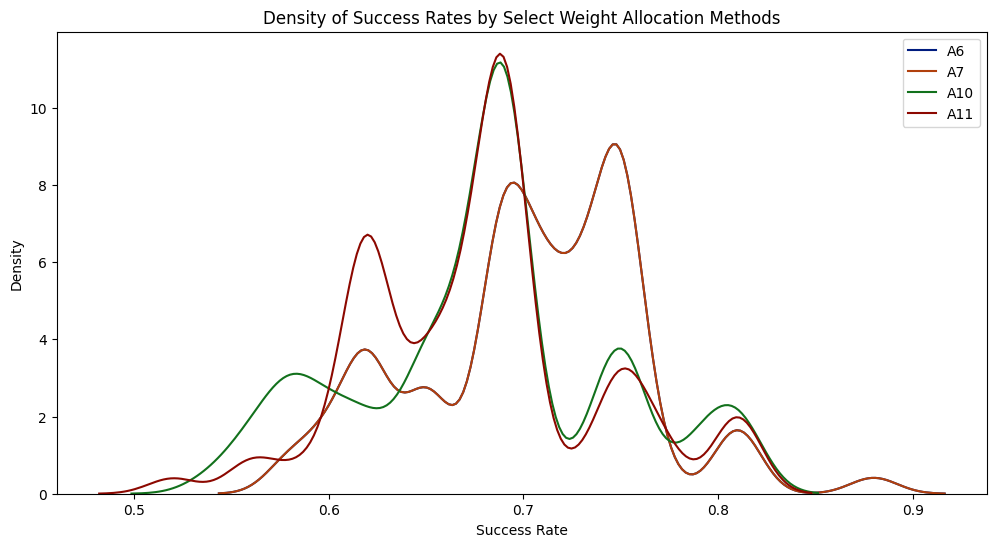

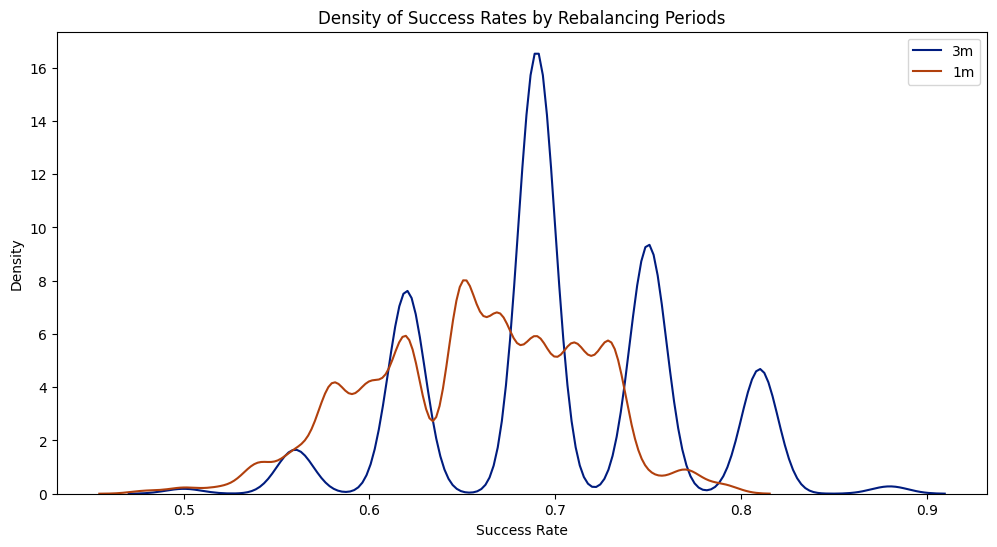

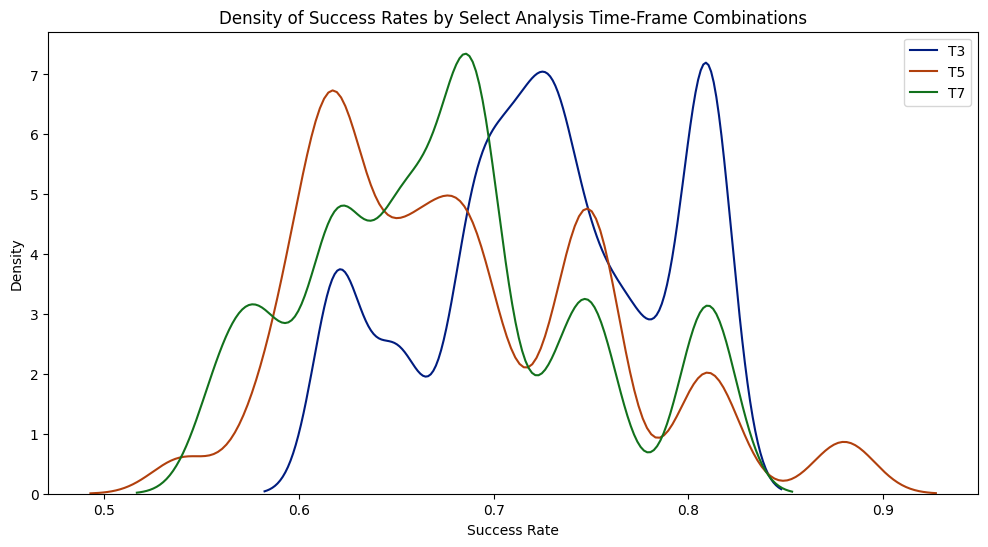

In [168]:
plot_density_curves_for_comparison(df_backup, stock_selection_methods_to_consider, 'Success_Rate', 'Density of Success Rates by Select Stock Selection Methods', 'Success Rate', 'Density', 'Stock_Selection_Method')
plot_density_curves_for_comparison(df_backup, weight_allocation_methods_to_consider, 'Success_Rate', 'Density of Success Rates by Select Weight Allocation Methods', 'Success Rate', 'Density', 'Weight_Allocation_Method')
plot_density_curves_for_comparison(df_backup, df_backup['Rebalance'].unique(), 'Success_Rate', 'Density of Success Rates by Rebalancing Periods', 'Success Rate', 'Density', 'Rebalance')
plot_density_curves_for_comparison(df_backup, backtesting_versions_to_consider, 'Success_Rate', 'Density of Success Rates by Select Analysis Time-Frame Combinations', 'Success Rate', 'Density', 'Analysis_Time_Frame_Combinations')